# Traction Analytics of News Articles

### Table of Contents

1. Data Preparation
2. Feature Engineering
3. Exploratory Data Analysis
4. Data Labelling
5. Model Building
6. Model Evaluation

### 1. Data Preparation

In [132]:
import pandas as pd
import ast 

pd.set_option('display.max_colwidth', None)

In [133]:
def load_data(filename):
    df = pd.read_csv("data/may_june_data_merged.csv") #.head(100)

    # Selecting Relevent Columms
    df = df[
        [
            "published",
            "headline",
            "summary",
            "link",
            "domain",
            "facebook_interactions",
            "date_extracted",
            "suggested_labels",
        ]
    ]

    # Converting published column to datetime
    df["published"] = pd.to_datetime(df["published"])
    df["date_extracted"] = pd.to_datetime(df["date_extracted"])

    # Extracting theme and index for each article
    df["suggested_labels"] = df["suggested_labels"].apply(lambda x: ast.literal_eval(x))
    df["article_theme"] = df["suggested_labels"].apply(lambda x: x[0].split(" > ")[0])
    df["article_index"] = df["suggested_labels"].apply(lambda x: x[0].split(" > ")[1])
    df = df.drop(columns=["suggested_labels"])

    # Sort articles
    df = df.sort_values(
        by=["headline", "published", "date_extracted"], ascending=[False, True, True]
    ).reset_index(drop=True)
    return df


def create_unique_df(df):
    df_unique = df.drop_duplicates(
        subset=["headline", "published"], keep="first"
    ).reset_index(drop=True)
    # Remove articles with indexes having less than 2 occurences
    df_unique = df_unique.groupby("article_index").filter(lambda x: len(x) > 1)

    return df_unique

In [134]:
df = load_data('data/may_june_data_merged.csv')
df_unique = create_unique_df(df)

### 2. Feature Engineering

In [135]:
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

General Feature Engineering

In [136]:
def engineer_features(df_unique):

    # Concat headline and summary
    df_unique['text'] = df_unique['headline'] + ' ' + df_unique['summary']

    # creature a feature for the number of hours since the article of the same article_index was published
    df_unique['hours_since_published'] = df_unique.sort_values(by=['published']).groupby(['article_index'])['published'].diff().dt.total_seconds().div(3600)
    df_unique['hours_since_published'] = df_unique['hours_since_published'].fillna(0)

    # create a feature for day of week published
    df_unique['day_of_week_published'] = df_unique['published'].dt.day_name().map({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6,'Sunday': 7})

    # Create a featyre for hour of day published
    df_unique['hour_of_day_published'] = df_unique['published'].dt.hour

    # create a feature for number of words in headline
    df_unique['headline_word_count'] = df_unique['headline'].str.split().str.len()

    # create a feature for number of words in summary
    df_unique['summary_word_count'] = df_unique['summary'].str.split().str.len()

    # create a feature for number of words in text
    df_unique['text_word_count'] = df_unique['text'].str.split().str.len()

    # create a feature for number of non-stop words in headline and summary
    stop_words = set(stopwords.words('english'))
    df_unique['headline_non_stop_word_count'] = df_unique['headline'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))
    df_unique['summary_non_stop_word_count'] = df_unique['summary'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))
    df_unique['text_non_stop_word_count'] = df_unique['text'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))

    # create a feature for number of unique words in headline and summary
    df_unique['headline_unique_word_count'] = df_unique['headline'].apply(lambda x: len(set([word for word in str(x).split()])))
    df_unique['summary_unique_word_count'] = df_unique['summary'].apply(lambda x: len(set([word for word in str(x).split()])))
    df_unique['text_unique_word_count'] = df_unique['text'].apply(lambda x: len(set([word for word in str(x).split()])))

    # creature a feature for the sentiment of the headline and summary
    df_unique['headline_sentiment'] = df_unique['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_unique['summary_sentiment'] = df_unique['summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_unique['text_sentiment'] = df_unique['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    # create a feature for the subjectivity of the headline and summary
    df_unique['headline_subjectivity'] = df_unique['headline'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df_unique['summary_subjectivity'] = df_unique['summary'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df_unique['text_subjectivity'] = df_unique['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # Remove NA rows
    df_unique = df_unique.dropna()

    return df_unique

Web Traffic Data

In [137]:
domain_map = {
    'asiaone': ['asiaone.com'],
    'businesstimes': ['businesstimes.com.sg'],
    'channelnewsasia': ['channelnewsasia.com', 'cnalifestyle.channelnewsasia.com', 'cnaluxury.channelnewsasia.com'],
    'goodyfeed': ['goodyfeed.com'],
    'mothership': ['babelfish.mothership.sg', 'mothership.sg', ],
    'mustsharenews': ['mustsharenews.com'],
    'ricemedia': ['ricemedia.co'],
    'straitstimes': ['straitstimes.com'],
    'stomp': ['stomp.straitstimes.com'],
    'thenewpaper': ['tnp.straitstimes.com'],
    'theonlinecitizen': ['theonlinecitizen.com'],
    'today': ['todayonline.com'],
    'yahoosingapore': ['sg.finance.yahoo.com', 'sg.news.yahoo.com', 'sg.style.yahoo.com'],
    # 'others': ['au.lifestyle.yahoo.com', 'au.news.yahoo.com','coconuts.co','malaysia.news.yahoo.com','public.flourish.studio', 'uk.news.yahoo.com']
}

reverse_domain_map = {}
for key, value in domain_map.items():
    for v in value:
        reverse_domain_map[v] = key

domain_traffic = {
    'asiaone': [4990000,1290000],
    'businesstimes': [1630000, 622688],
    'channelnewsasia': [14760000, 2330000],
    'goodyfeed': [891376, 461731],
    'mothership': [6770000, 1660000],
    'mustsharenews': [2010000, 823526],
    'ricemedia': [148791, 86394],
    'straitstimes': [12310000, 2230000],
    'stomp': [1270000, 427113],
    'theindependent': [2370000, 683818],
    'thenewpaper': [707314, 350734],
    'theonlinecitizen': [657013, 233237],
    'today': [3660000, 1170000],
    'yahoosingapore': [5010000, 561434],
}

traffic_table = pd.DataFrame.from_dict(domain_traffic, orient='index', columns=['mean_monthly_visits', 'mean_monthly_unique_visitors']).reset_index().rename(columns={'index':'domain_group'})

In [138]:
def filter_df(df):
    df = df[df["domain"].isin([i for a in list(domain_map.values()) for i in a])]
    return df

def merge_traffic_table(df_unique):
    df_unique['domain_group'] = df_unique['domain'].map(reverse_domain_map)
    df_unique = df_unique.merge(traffic_table, on='domain_group', how='left')
    return df_unique

In [139]:
df = filter_df(df)

df_unique = engineer_features(df_unique)

df_unfiltererd = df_unique.copy()

df_unique = filter_df(df_unique)
df_unique = merge_traffic_table(df_unique)

### 3. Exploratory Data Analysis

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

Theme and Index Analysis

In [141]:
def plot_themes(df_unique):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(y="article_theme", data=df_unique, ax=ax, order=df_unique['article_theme'].value_counts().index)
    ax.set_title("Theme Distribution")
    ax.set_xlabel("Theme")
    ax.set_ylabel("Count")
    plt.show()

def plot_index(df_unique):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.countplot(y="article_index", data=df_unique, ax=ax, order=df_unique['article_index'].value_counts().index)
    ax.set_title("Index Distribution")
    ax.set_xlabel("Index")
    ax.set_ylabel("Count")
    plt.show()

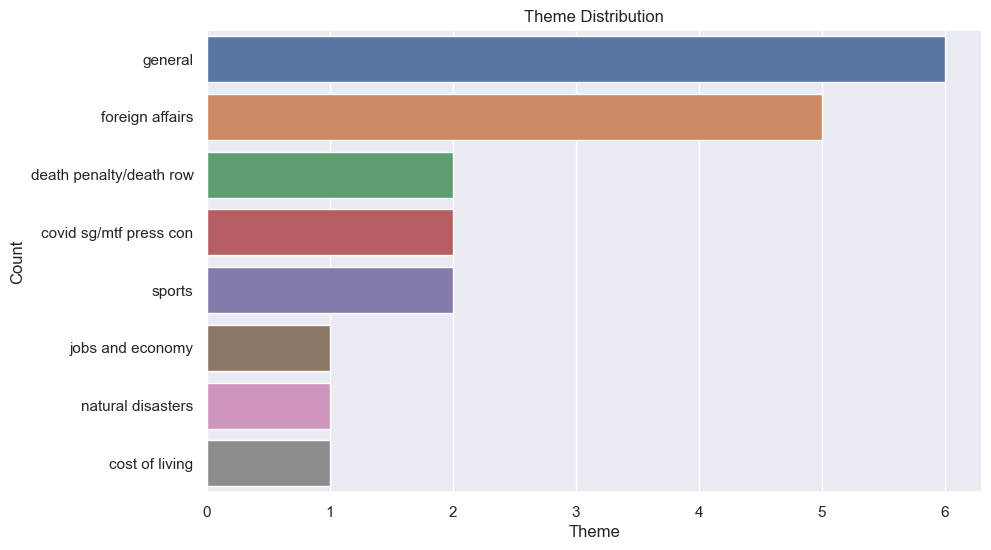

In [142]:
plot_themes(df_unique)

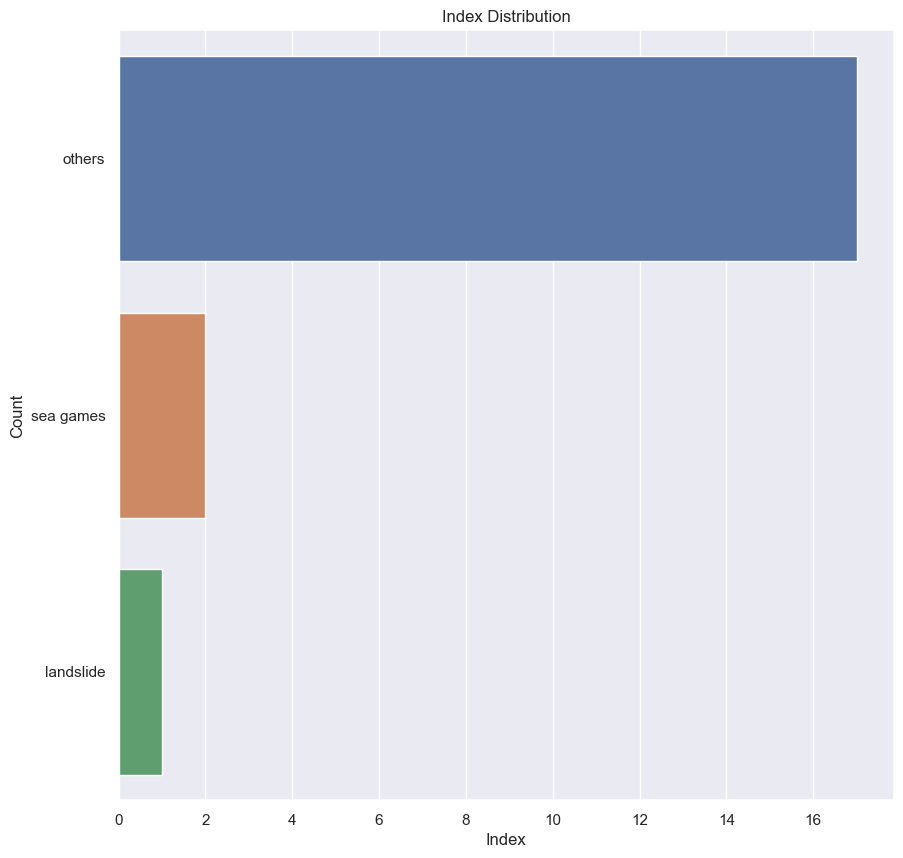

In [143]:
plot_index(df_unique)

Domain Analysis

In [144]:
def plot_domains(df_unique):
    plt.figure(figsize=(10, 6))
    sns.countplot(y='domain', data=df_unique, order=df_unique['domain'].value_counts().index)
    plt.title('Number of articles per domain')
    plt.xlabel('Number of articles')
    plt.ylabel('Domain')
    plt.show()

def plot_domain_group(df_unique):
    plt.figure(figsize=(10, 6))
    sns.countplot(y='domain_group', data=df_unique, order=df_unique['domain_group'].value_counts().index)
    plt.title('Number of articles per domain group')
    plt.xlabel('Number of articles')
    plt.ylabel('Domain Group')
    plt.show()

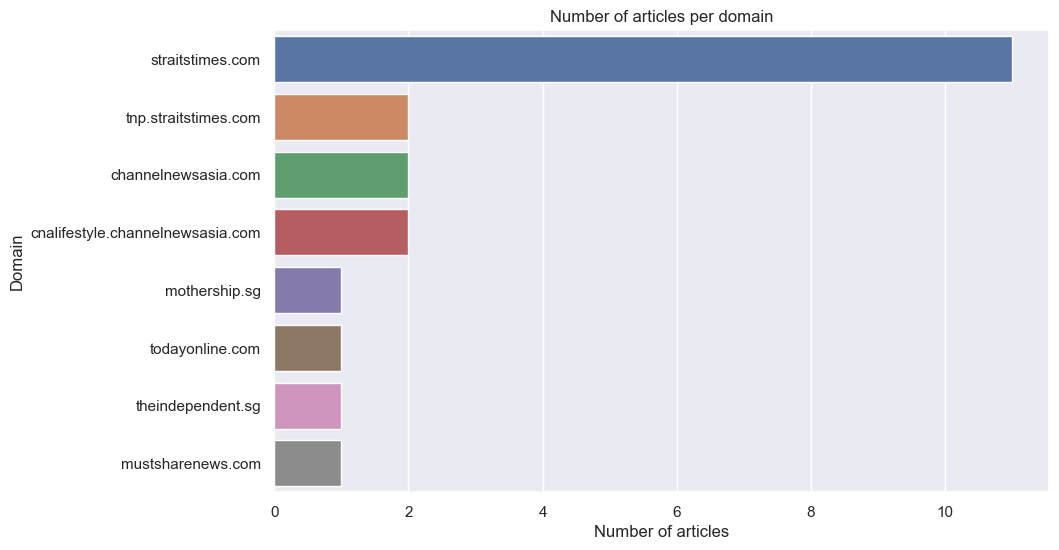

In [145]:
plot_domains(df_unfiltererd)

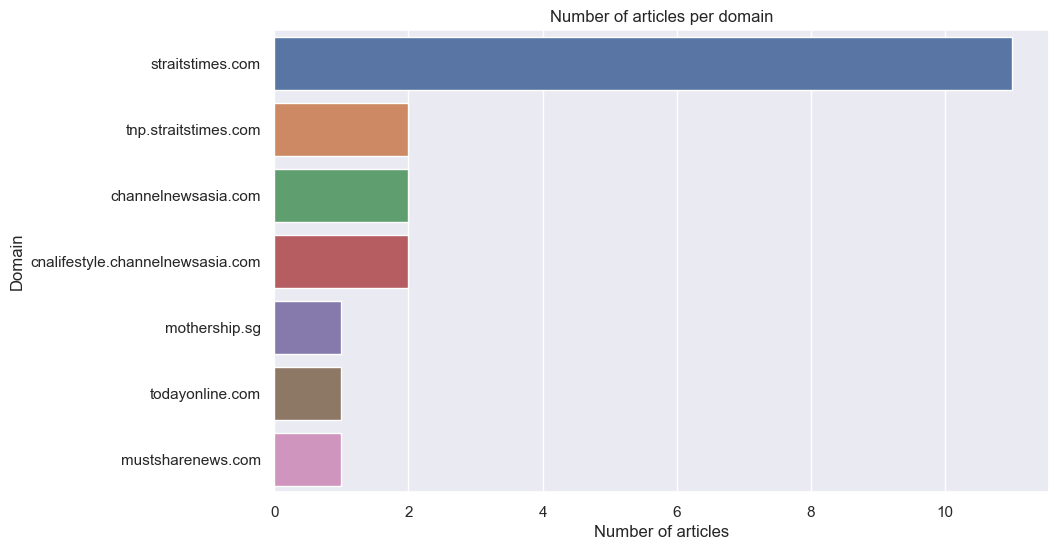

In [146]:
plot_domains(df_unique)

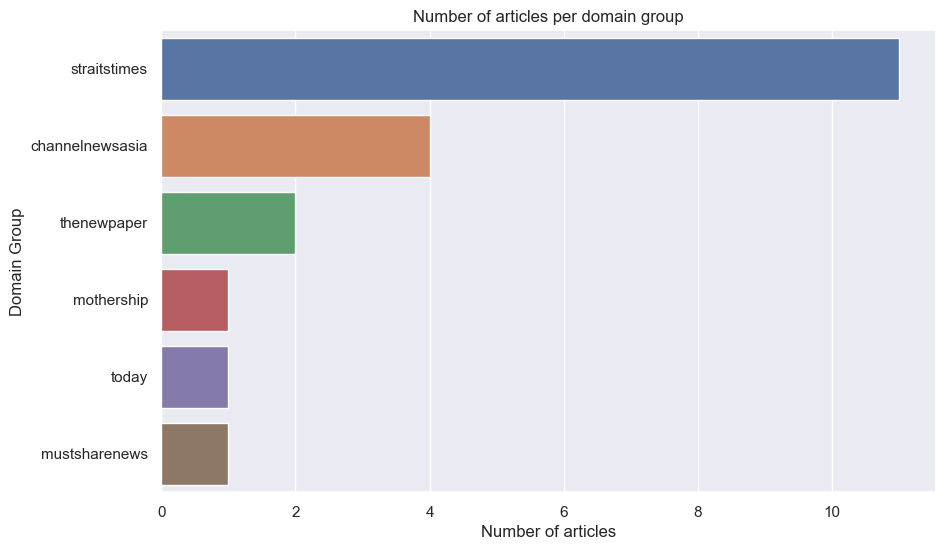

In [147]:
plot_domain_group(df_unique)

In [148]:
def plot_hisplot(df, col, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, bins=100, kde=True)
    plt.title(title)
    plt.show()

def display_sample_higher(df, col, threshold):
    return df[df[col] > threshold][['headline','article_index',col]].head(15).sort_values(by=col, ascending=False)

def display_sample_lower(df, col, threshold):
    return df[df[col] < threshold][['headline','article_index',col]].head(15).sort_values(by=col, ascending=True)


Hours since last article of the same index was published

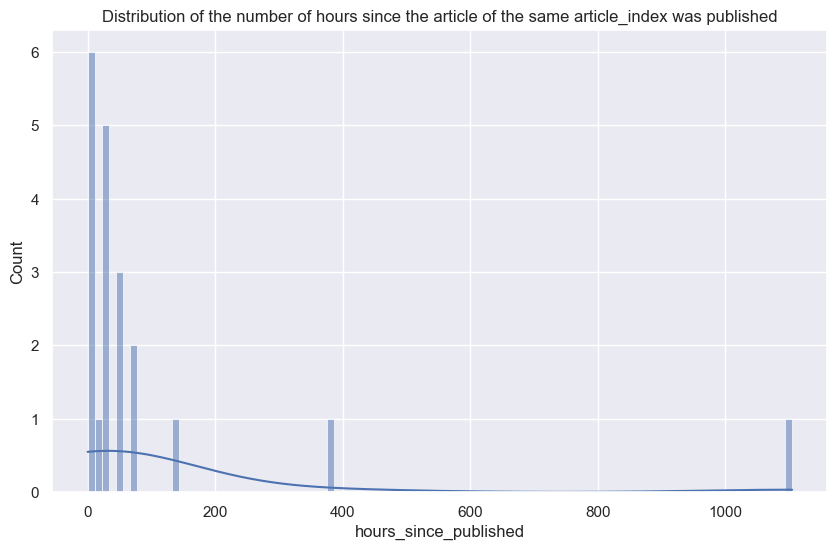

In [149]:
# Plot the distribution of the number of hours since the article of the same article_index was published

plot_hisplot(df_unique, 'hours_since_published', 'Distribution of the number of hours since the article of the same article_index was published')

In [150]:
display_sample_lower(df_unique, 'hours_since_published', 150)

,headline,article_index,hours_since_published
1,"â€˜We will always have your back': 4G team will look after workers in these dark times, says DPM Wong",others,0.000000
11,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has Everybody Wondering If Heâ€™s Okay,sea games,0.000000
7,"â€˜Sad and inhumane': Yishun resident finds nearly 30 pigeons, most of them dead, lying near HDB blocks",others,1.127500
5,â€˜The Godfather of AIâ€™ leaves Google and warns of danger ahead,others,1.334722
9,â€˜My husband checked for hidden cameras in our home toilet': Voyeur's victim still scarred,others,3.343333
8,"â€˜Sad and inhumane': Yishun resident finds nearly 30 pigeons, most of them dead, lying near HDB blocks",others,5.831667
0,â€˜Why is your client smiling?' Judge asks lawyer of voyeur who filmed women nearly 100 times,others,21.663611
14,â€˜I will miss you': Patrons bid farewell to iconic Popular bookstore outlet at Marine Parade,others,23.951944
15,â€˜I was just super pumpedâ€™: Singapore's Shanti Pereira blazes to SEA Games gold as records fall,sea games,26.470556
6,â€˜The Godfather of AI' leaves Google and warns of danger ahead,others,27.534722


In [151]:
display_sample_higher(df_unique, 'hours_since_published', 150)

,headline,article_index,hours_since_published
4,â€˜There will never be another You': Wife of missing Everest climber in tribute post,landslide,1105.003611
3,â€˜Wang hong' culture booms in China as more young people dream of becoming influencers,others,383.501944


Number of words in text

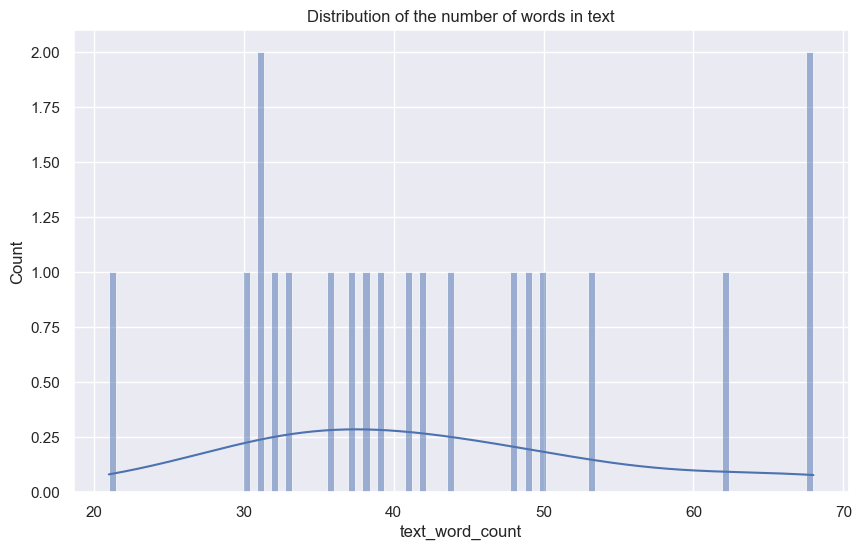

In [152]:
# Plot the distribution of the number of words in text

plot_hisplot(df_unique, 'text_word_count', 'Distribution of the number of words in text')

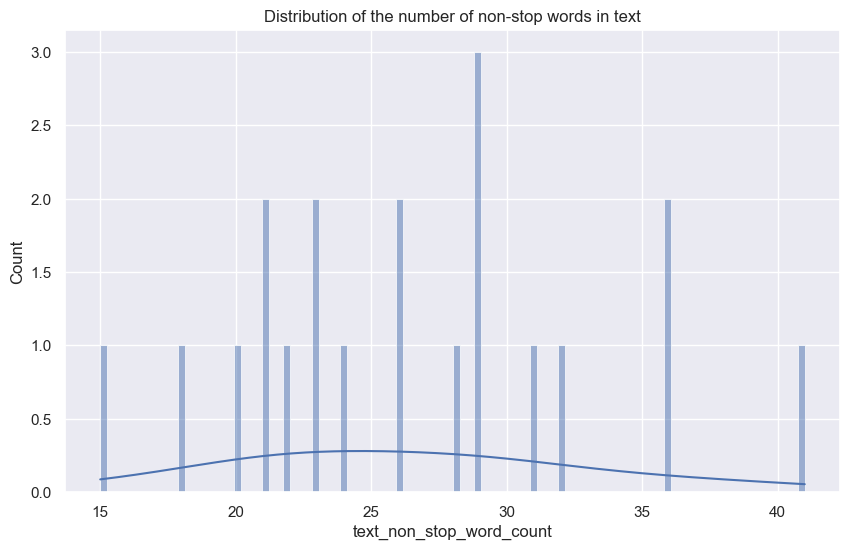

In [153]:
# Plot the distribution of the number of non-stop words in text

plot_hisplot(df_unique, 'text_non_stop_word_count', 'Distribution of the number of non-stop words in text')

Sentiment Analysis

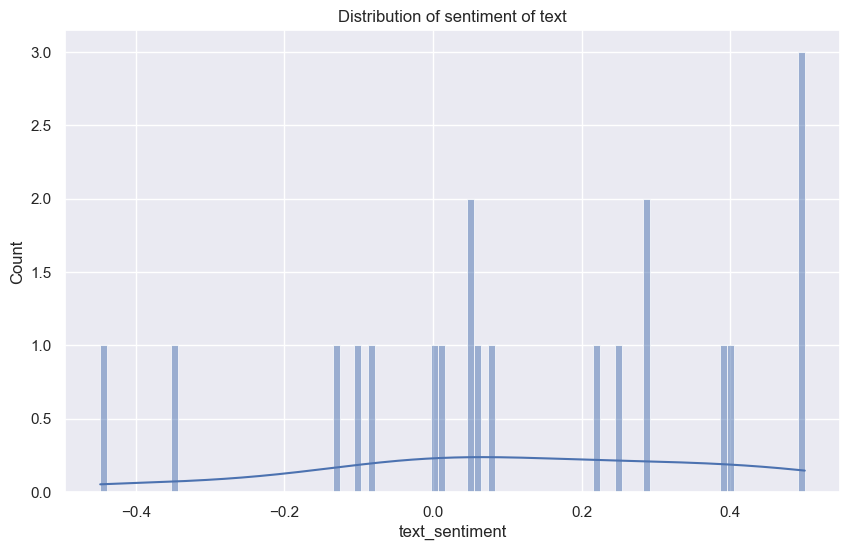

In [154]:
# Plot the distribution of sentiment of text

plot_hisplot(df_unique, 'text_sentiment', 'Distribution of sentiment of text')

In [155]:
display_sample_higher(df_unique, 'text_sentiment', 0.75)

,headline,article_index,text_sentiment


In [156]:
display_sample_lower(df_unique, 'text_sentiment', -0.55)

,headline,article_index,text_sentiment


Subjectivity Analysis

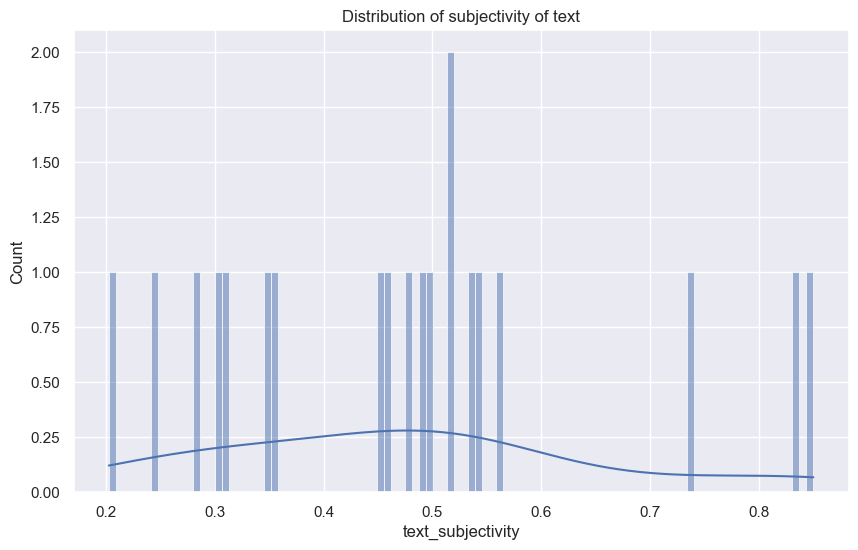

In [157]:
# Plot the distribution of subjectivity of text

plot_hisplot(df_unique, 'text_subjectivity', 'Distribution of subjectivity of text')

In [158]:
display_sample_higher(df_unique, 'text_subjectivity', 0.75)

,headline,article_index,text_subjectivity
17,â€˜I now realise I cannot control everything in my lifeâ€™: A mum on how IVF changed her view of motherhood,others,0.850000
16,"â€˜I think people deserve to vote', says George Goh who hopes to run for president",others,0.833333


In [159]:
display_sample_lower(df_unique, 'text_subjectivity', 0.25)

,headline,article_index,text_subjectivity
18,"â€˜I know what itâ€™s like to be homeless and helplessâ€™: After her mum left the family when she was 15, she took over",others,0.202778
1,"â€˜We will always have your back': 4G team will look after workers in these dark times, says DPM Wong",others,0.244444


Time of Posting Analysis

In [160]:
def agg_post_count_by_time(df_unique, agg_col, top_n=2):
    return (
        df_unique.groupby([agg_col, "domain_group"])
        .agg({"article_index": "count"})
        .reset_index()
        .sort_values(by=[agg_col, "article_index"], ascending=False)
        .groupby(agg_col)
        .head(top_n)
        .rename(columns={"article_index": "count"})
        .sort_values(by=[agg_col, 'count'], ascending=[True, False])
        .reset_index(drop=True)
    )

def plot_post_count_by_time(df_unique, agg_col, top_n=2):
    df = agg_post_count_by_time(df_unique, agg_col, top_n)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=agg_col, y="count", hue="domain_group")
    plt.title(f"Top {top_n} domains by {agg_col}")
    plt.show()

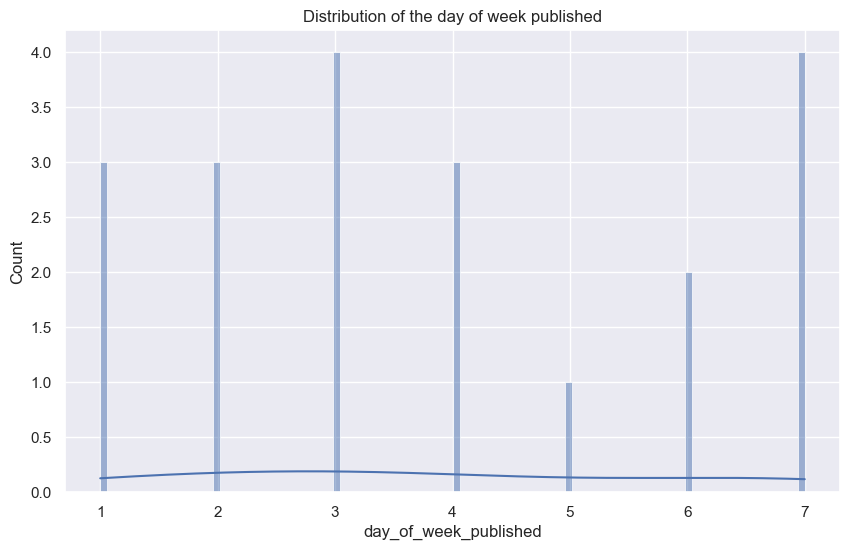

In [161]:
# Plot the distribution of the day of week published

plot_hisplot(df_unique, 'day_of_week_published', 'Distribution of the day of week published')

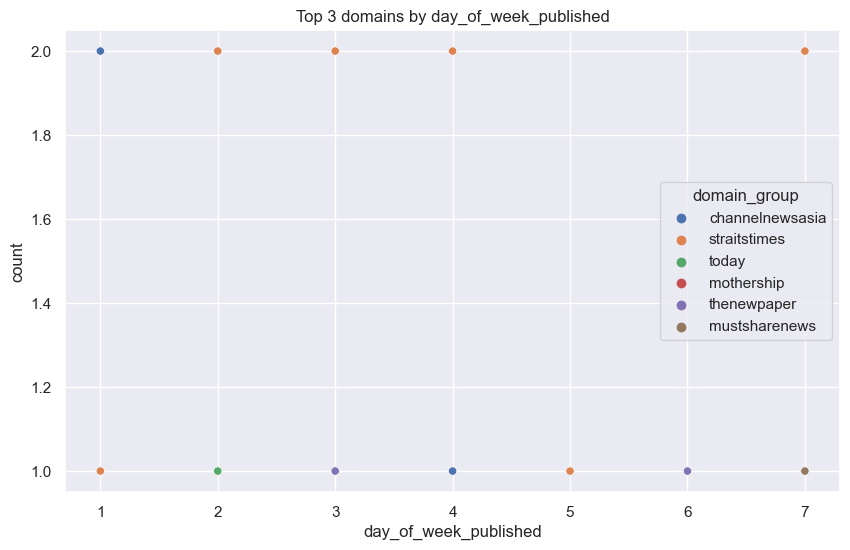

In [162]:
# Calculate on each day of the week, the domain_group with the highest mean number of articles published

plot_post_count_by_time(df_unique, "day_of_week_published", top_n=3)

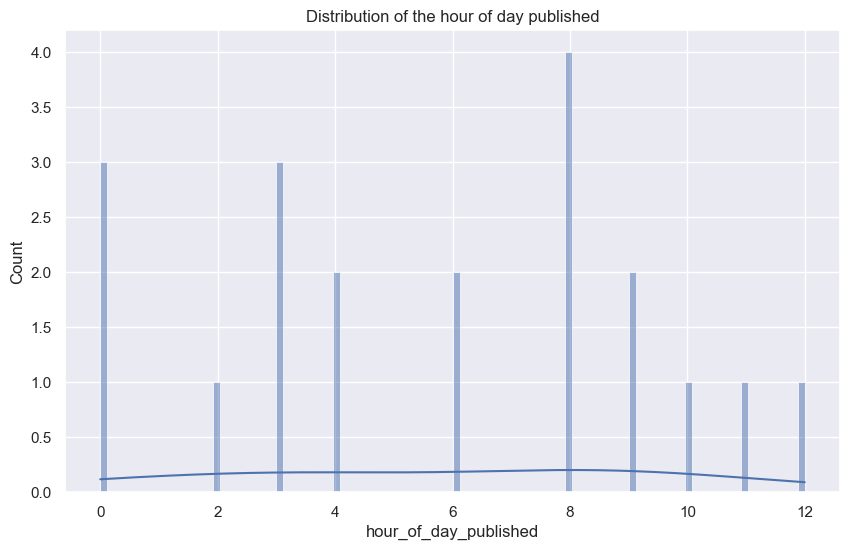

In [163]:
# Plot the distribution of the hour of day published

plot_hisplot(df_unique, 'hour_of_day_published', 'Distribution of the hour of day published')

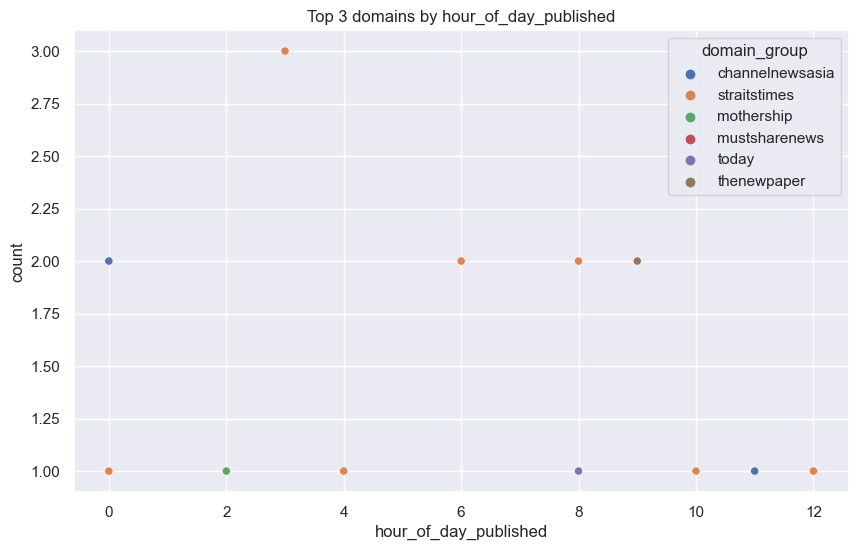

In [164]:
# Calculate on each hour of the day, the domain_group with the highest mean number of articles published

plot_post_count_by_time(df_unique, "hour_of_day_published", top_n=3)


### 4. Data Labelling

In [165]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer


In [166]:
GRD_THRESHOLD_UPPER = 1
GRD_THRESHOLD_LOWER = -1
VAL_ARR_THRESHOLD_UPPER = 1
VAL_ARR_THRESHOLD_LOWER = -1

In [167]:
def cal_article_mean_and_gradient(val_array):
    val_array = np.asarray(val_array)
    mean = np.mean(val_array)
    val_array = np.nan_to_num(val_array)
    model = LinearRegression()
    model.fit(np.arange(len(val_array)).reshape(-1, 1), val_array)
    gradient = model.coef_[0]
    return mean, gradient

def agg_mean_and_gradient(df):
    df_agg = df.groupby('link')['facebook_interactions'].agg(cal_article_mean_and_gradient).reset_index()
    return df_agg

def merge_labels(df_unique, df_agg):
    df_labelled = df_unique.merge(df_agg, on='link', how='left')
    df_labelled = df_labelled.rename(columns={'facebook_interactions_x': 'facebook_interactions', 'facebook_interactions_y': 'mean_and_gradient'})
    df_labelled['mean'] = df_labelled['mean_and_gradient'].apply(lambda x: x[0])
    df_labelled['gradient'] = df_labelled['mean_and_gradient'].apply(lambda x: x[1])
    df_labelled.drop(columns=['mean_and_gradient'], inplace=True)
    df_labelled['gradient'] = df_labelled['gradient'].apply(lambda x: 0 if x < 0 else x)
    return df_labelled

def normalise_mean_and_gradient(df_labelled):
    df_labelled['mean_s_scaled'] = StandardScaler().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_s_scaled'] = StandardScaler().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_r_scaled'] = RobustScaler().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_r_scaled'] = RobustScaler().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_log'] = np.log(df_labelled['mean'])
    df_labelled['gradient_log'] = np.log(df_labelled['gradient'])
    return df_labelled

def plot_gradient(df_labelled):
    fig, ax = plt.subplots(1, 7, figsize=(35, 5))
    sns.histplot(data=df_labelled, x='gradient', bins=100, kde=True, ax=ax[0])
    sns.histplot(data=df_labelled, x='gradient_s_scaled', bins=100, kde=True, ax=ax[1])
    sns.histplot(data=df_labelled, x='gradient_mm_scaled', bins=100, kde=True, ax=ax[2])
    sns.histplot(data=df_labelled, x='gradient_r_scaled', bins=100, kde=True, ax=ax[3])
    sns.histplot(data=df_labelled, x='gradient_pt_scaled', bins=100, kde=True, ax=ax[4])
    sns.histplot(data=df_labelled, x='gradient_qt_scaled', bins=100, kde=True, ax=ax[5])
    sns.histplot(data=df_labelled, x='gradient_log', bins=100, kde=True, ax=ax[6])
    plt.show()

def plot_mean(df_labelled):
    fig, ax = plt.subplots(1, 7, figsize=(35,5))
    sns.histplot(data=df_labelled, x='mean', bins=100, kde=True, ax=ax[0])
    sns.histplot(data=df_labelled, x='mean_s_scaled', bins=100, kde=True, ax=ax[1])
    sns.histplot(data=df_labelled, x='mean_mm_scaled', bins=100, kde=True, ax=ax[2])
    sns.histplot(data=df_labelled, x='mean_r_scaled', bins=100, kde=True, ax=ax[3])
    sns.histplot(data=df_labelled, x='mean_pt_scaled', bins=100, kde=True, ax=ax[4])
    sns.histplot(data=df_labelled, x='mean_qt_scaled', bins=100, kde=True, ax=ax[5])
    sns.histplot(data=df_labelled, x='mean_log', bins=100, kde=True, ax=ax[6])
    plt.show()

def get_label(row, colums):
    gradient_index = colums.index('gradient_pt_scaled')
    mean_index = colums.index('mean_pt_scaled')

    if row[gradient_index] > GRD_THRESHOLD_UPPER or row[mean_index] > VAL_ARR_THRESHOLD_UPPER:
        return "trending"
    
    elif row[gradient_index] < GRD_THRESHOLD_LOWER or row[mean_index] < VAL_ARR_THRESHOLD_LOWER:
        return "diminishing"
    
    else:
        return "neutral"
    
def map_labels_to_numertical(df_labelled):
    label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
    df_labelled['label'] = df_labelled['label'].map(label_mapper)
    return df_labelled
    
def plot_labels(df_labelled):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_labelled, x='label')
    plt.title('Distribution of Target Variable')
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.show()

def merge_labels_to_main(df_labelled, df):
    df_combined = df.merge(df_labelled[['link', 'label']], on='link', how='left')
    return df_combined

def get_article_activity_by_day(df_labelled, df):
    df_combined = df.merge(df_labelled[['link', 'label']], on='link', how='left')
    unique_articles = df_combined['link'].unique()
    activity_df = pd.DataFrame()

    for article in unique_articles:
        df_slice = df_combined[df_combined['link'] == article].reset_index(drop=True)
        df_slice = df_slice.reset_index().rename(columns={'index': 'day'})
        df_slice['day'] = df_slice['day'] + 1
        activity_df = activity_df.append(df_slice)

    return activity_df
    
def plot_activities(activity_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=activity_df, x='day', y='facebook_interactions', hue='label')
    plt.title('Facebook Interactions over Days')
    plt.xlabel('Day')
    plt.ylabel('Facebook Interactions')
    plt.show()



In [168]:
df_agg = agg_mean_and_gradient(df)
df_labelled = merge_labels(df_unique, df_agg)
df_labelled = normalise_mean_and_gradient(df_labelled)
df_labelled['label'] = df_labelled.apply(lambda x: get_label(x, list(df_labelled.columns)), axis=1)

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


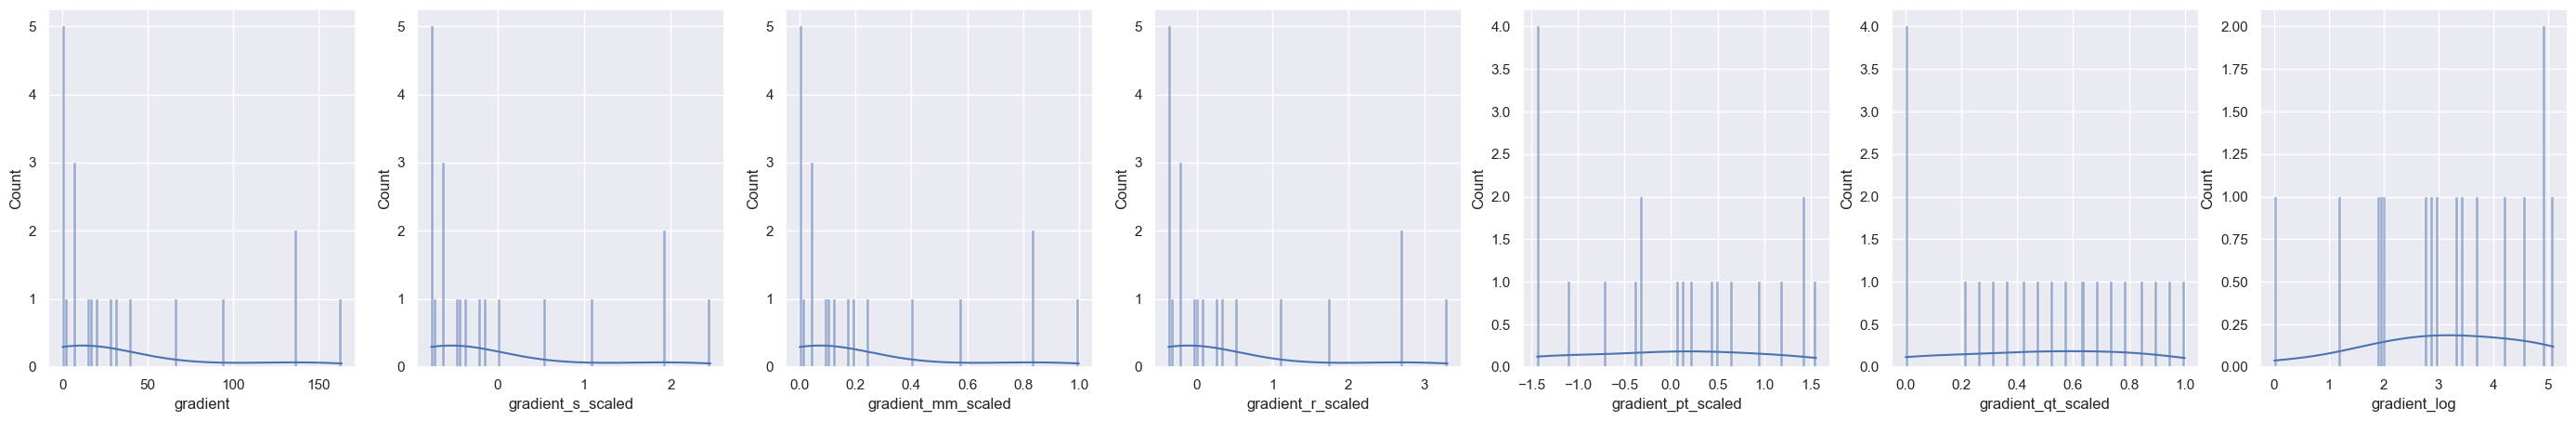

In [169]:
plot_gradient(df_labelled)

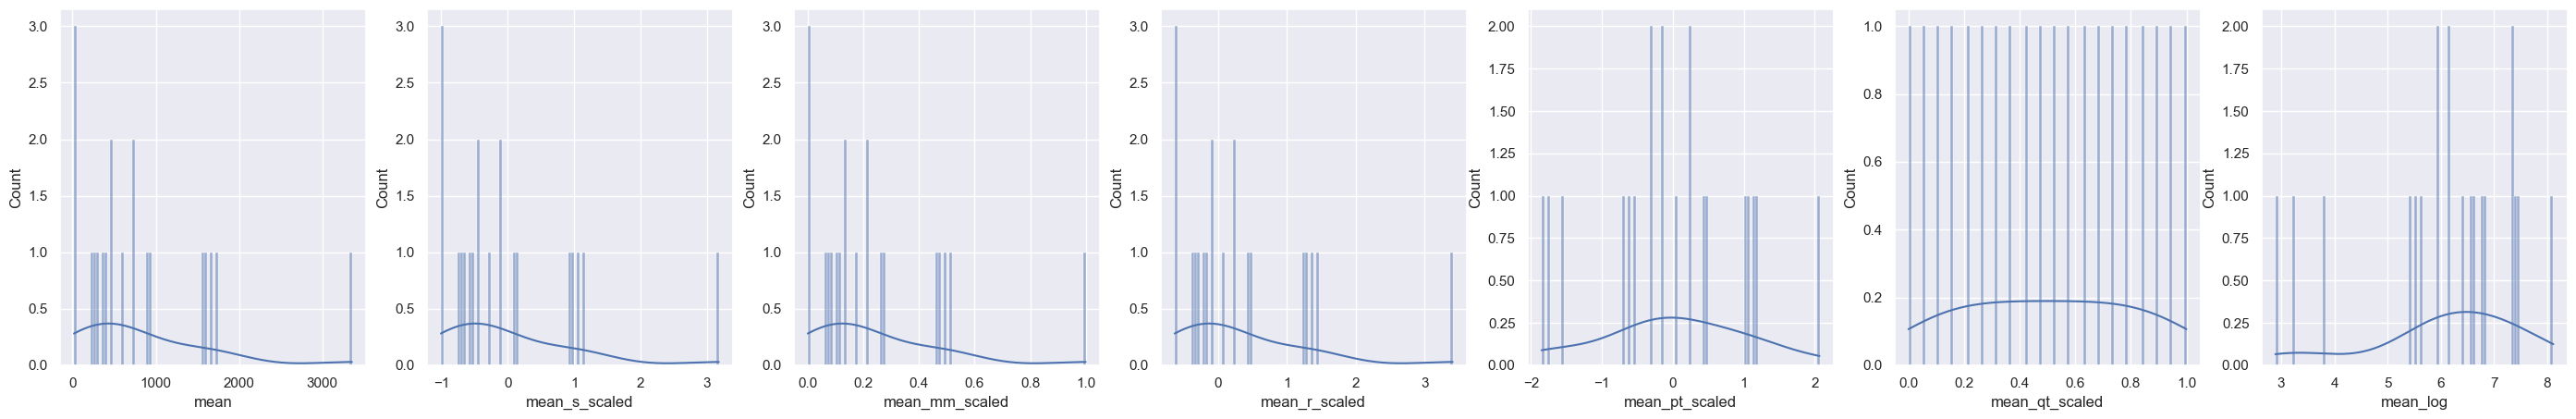

In [170]:
plot_mean(df_labelled)

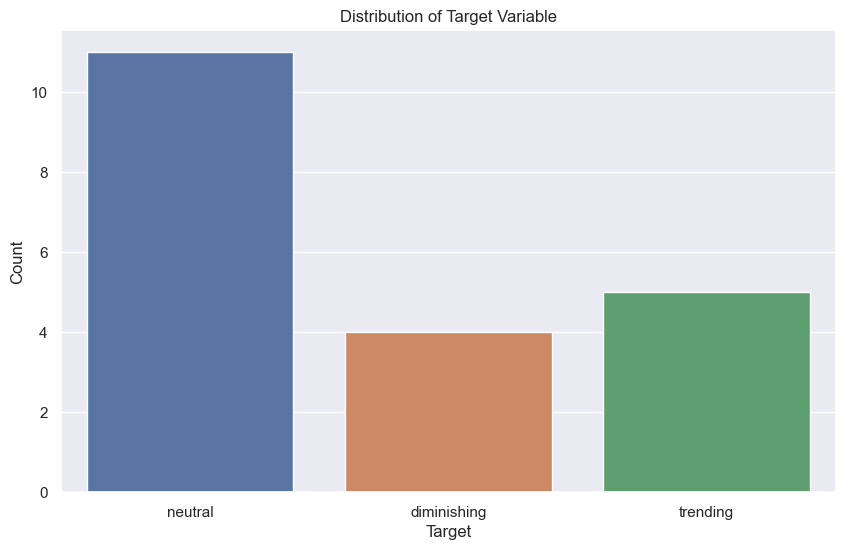

In [171]:
plot_labels(df_labelled)

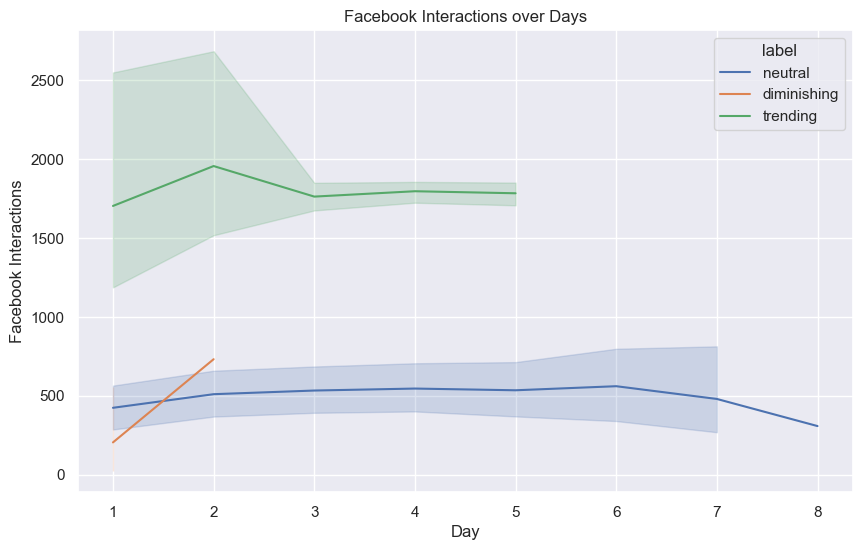

In [172]:
activity_df = get_article_activity_by_day(df_labelled, df)
plot_activities(activity_df)

In [173]:
df_labelled = map_labels_to_numertical(df_labelled)

Index Traction by Aggregation (Majority Weighted Voting)

In [174]:
def get_index_aggregated_labels(df_labelled, col_name):
    df_agg = df_labelled.copy()
    df_agg[f'{col_name}_d'] = df_agg[col_name].apply(lambda x: x)
    df_agg = pd.get_dummies(df_agg, columns=[f'{col_name}_d'])
    dummy_label_cols = [col for col in df_agg.columns if f'{col_name}_d' in col]

    # Assuming equal weighted voting
    df_agg["vote_weights"] = 1

    for col in dummy_label_cols:
        df_agg[col] = df_agg[col] * df_agg['vote_weights']

    df_agg = df_agg.groupby('article_index')[dummy_label_cols].sum().idxmax(axis=1).reset_index().rename(columns={0: 'label'})
    df_agg['label'] = df_agg[col_name].apply(lambda x: int(x[-1]))
    return df_agg.sort_values(by='label', ascending=False).reset_index(drop=True)


In [175]:
get_index_aggregated_labels(df_labelled, 'label')

,article_index,label
0,landslide,1
1,others,1
2,sea games,1


### 5. Model Building

In [176]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [177]:
RESULTS_STORE = {}

In [178]:
def display_results_store_article():
    df_combined_results = pd.DataFrame()
    for key, value in RESULTS_STORE.items():
        results_key = pd.DataFrame(RESULTS_STORE[key])
        results_key.drop(columns='index_level', inplace=True)
        results_key.rename(columns={'article_level': f'{key}'}, inplace=True)
        df_combined_results = pd.concat([df_combined_results, results_key], axis=1)

    return df_combined_results

def display_results_store_index():
    df_combined_results = pd.DataFrame()
    for key, value in RESULTS_STORE.items():
        results_key = pd.DataFrame(RESULTS_STORE[key])
        results_key.drop(columns='article_level', inplace=True)
        results_key.rename(columns={'index_level': f'{key}'}, inplace=True)
        df_combined_results = pd.concat([df_combined_results, results_key], axis=1)

    return df_combined_results

def evaluate_predictions(test_y, pred_y):
    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average="macro")
    recall = recall_score(test_y, pred_y, average="macro")
    f1 = f1_score(test_y, pred_y, average="macro")

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame(
        {"accuracy": [acc], "precision": [precision], "recall": [recall], "f1": [f1]}
    )
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: "macro"})


def get_predictions_agg(test_dataset, pred_y, weighted=False):
    if not isinstance(test_dataset, pd.DataFrame):
        test_dataset_merge = test_dataset.to_pandas()
    else:
        test_dataset_merge = test_dataset.copy()
    test_dataset_merge["pred_y"] = pred_y

    if weighted:
        # convert label to one-hot encoding
        test_dataset_merge["label_d"] = test_dataset_merge["label"].apply(lambda x: x)
        test_dataset_merge["pred_y_d"] = test_dataset_merge["pred_y"].apply(lambda x: x)
        test_dataset_merge = pd.get_dummies(test_dataset_merge, columns=["label_d"])
        test_dataset_merge = pd.get_dummies(test_dataset_merge, columns=["pred_y_d"])

        dummy_label_cols = [
            col for col in test_dataset_merge.columns if "label_d" in col
        ]
        dummy_pred_cols = [
            col for col in test_dataset_merge.columns if "pred_y_d" in col
        ]

        test_dataset_merge["vote_weights"] = (
            1 / test_dataset_merge["hours_since_published"]
        )

        # weighted voting
        for col in dummy_label_cols:
            test_dataset_merge[col] = (
                test_dataset_merge[col] * test_dataset_merge["vote_weights"]
            )

        for col in dummy_pred_cols:
            test_dataset_merge[col] = (
                test_dataset_merge[col] * test_dataset_merge["vote_weights"]
            )

        # aggregate each article_index by votes and return the label with the highest votes
        test_dataset_agg = (
            test_dataset_merge.groupby("article_index")[dummy_label_cols]
            .sum()
            .idxmax(axis=1)
            .reset_index()
            .rename(columns={0: "label"})
        )
        pred_agg = (
            test_dataset_merge.groupby("article_index")[dummy_pred_cols]
            .sum()
            .idxmax(axis=1)
            .reset_index()
            .rename(columns={0: "label"})
        )

        # Convert back to integer
        test_dataset_agg["label"] = test_dataset_agg["label"].apply(
            lambda x: int(x[-1])
        )
        pred_agg["pred_y"] = pred_agg["label"].apply(lambda x: int(x[-1]))

    else:
        test_dataset_agg = (
            test_dataset_merge.groupby("article_index")["label"]
            .agg(lambda x: x.value_counts().sort_values(ascending=False).index[0])
            .reset_index()
        )
        pred_agg = (
            test_dataset_merge.groupby("article_index")["pred_y"]
            .agg(lambda x: x.value_counts().sort_values(ascending=False).index[0])
            .reset_index()
        )
    # return test_dataset_agg, pred_agg
    return test_dataset_agg["label"], pred_agg["pred_y"]


def plot_confusion_matrix(test_y, pred_y, title):
    cm = confusion_matrix(test_y, pred_y, labels=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="g")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ["0", "1", "2"])
    plt.yticks([0.5, 1.5, 2.5], ["0", "1", "2"])
    plt.show()

#### Model 1: SetFit with Text Features Only (Summary + Headline)

In [179]:
def prepare_setfit_datasets_m1(df_labelled, columns, method_name):
    df = df_labelled.copy()
    df = df[columns]

    df = df.groupby("article_index").filter(lambda x: len(x) > 1)

    # split into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    train_df.to_parquet(f'data/train_df_{method_name}.parquet')
    test_df.to_parquet(f'data/test_df_{method_name}.parquet')

    dataset = load_dataset("parquet", data_files={'train': f"data/train_df_{method_name}.parquet", 'test': f"data/test_df_{method_name}.parquet"})
    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    return train_dataset, test_dataset

def train_evaluate_setfit_model(train_dataset, test_dataset, method_name):
    model = SetFitModel.from_pretrained(
        "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
        cache_dir="cached_models",
    )

    trainer = SetFitTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        loss_class=CosineSimilarityLoss,
        # metric="accuracy",
        batch_size=16,
        num_iterations=20, # The number of text pairs to generate for contrastive learning
        num_epochs=1, # The number of epochs to use for contrastive learning
        column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
    )

    trainer.train()
    
    test_y = test_dataset.to_pandas()['label']
    pred_y = model.predict(test_dataset.to_pandas()['text']).numpy()

    article_level_result = evaluate_predictions(test_y, pred_y).rename(columns={'macro': method_name})
    test_y_agg, pred_y_agg = get_predictions_agg(test_dataset, pred_y)
    index_level_result = evaluate_predictions(test_y_agg, pred_y_agg).rename(columns={'macro': method_name})

    if method_name not in RESULTS_STORE:
        RESULTS_STORE[method_name] = {'article_level': [], 'index_level': []}
    RESULTS_STORE[method_name]['article_level'] = article_level_result.to_dict()[method_name]
    RESULTS_STORE[method_name]['index_level'] = index_level_result.to_dict()[method_name]

    plot_confusion_matrix(test_y, pred_y, 'Article Level Confusion Matrix for ' + method_name)
    plot_confusion_matrix(test_y_agg, pred_y_agg, 'Index Level Confusion Matrix for ' + method_name)

    print('Article Level Results')
    display(display_results_store_article())
    print('Index Level Results')
    display(display_results_store_index())


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-ec0ef2c05dc0e3bf/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 999.95it/s]
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 5156.51it/s]
***** Running training *****
  Num examples = 600
  Num epochs = 1
  Total optimization steps = 38
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [00:19<00:00, 19.20s/it]
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefin

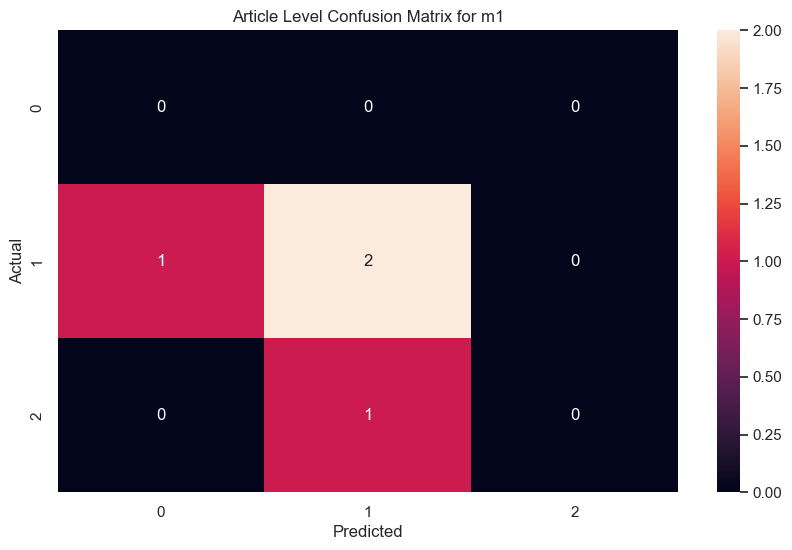

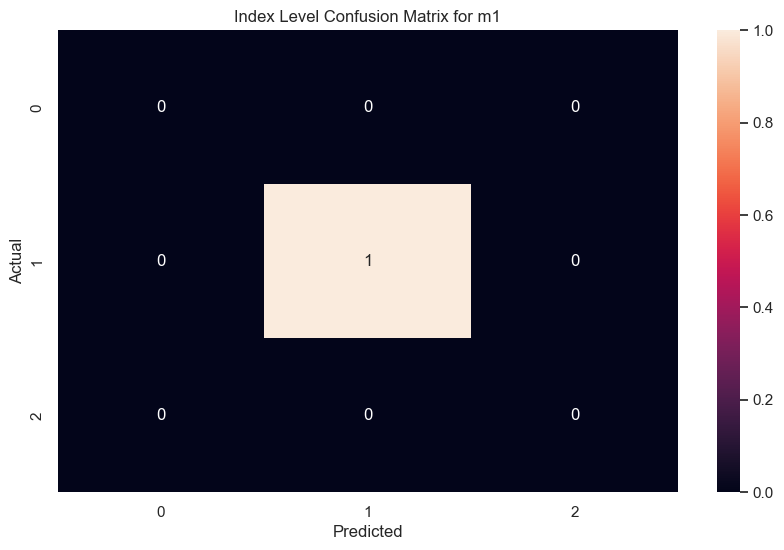

Article Level Results


,m1
accuracy,0.500
precision,0.222
recall,0.222
f1,0.222


Index Level Results


,m1
accuracy,1.0
precision,1.0
recall,1.0
f1,1.0


In [180]:
train_df_m1, test_df_m1 = prepare_setfit_datasets_m1(df_labelled, ['article_index', 'text', 'label'], 'm1')
train_evaluate_setfit_model(train_df_m1, test_df_m1, 'm1')

#### Model 2: SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Additional Features)

In [181]:
def prepare_setfit_datasets_m2(df_labelled, columns, method_name):
    df = df_labelled.copy()
    df = df[columns]

    df = df.groupby("article_index").filter(lambda x: len(x) > 1)

    df["text"] = (
        df["text"]
        + " There are "
        + df["mean_monthly_visits"].astype(str)
        + " mean monthly visitors to the website and "
        + df["mean_monthly_unique_visitors"].astype(str)
        + " mean monthly unique visitors to the website."
        
        # + " The article was published "
        # + df["hours_since_published"].astype(str)
        # + " hours after the last article of the same theme was published."
        # + " The article was published on the "
        # + df["day_of_week_published"].astype(str)
        # + " day of the week."
        # + " The article was published at the "
        # + df["hour_of_day_published"].astype(str)
        # + " hour of the day."
        # + " The headline has "
        # + df["text_non_stop_word_count"].astype(str)
        # + " non-stop words."
        # + " The text has a subjectivity score of "
        # + df["text_subjectivity"].astype(str)
        # + " and a sentiment score of "
        # + df["text_sentiment"].astype(str)
        # + "."
    )

    # split into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    train_df.to_parquet(f'data/train_df_{method_name}.parquet')
    test_df.to_parquet(f'data/test_df_{method_name}.parquet')

    dataset = load_dataset("parquet", data_files={'train': f"data/train_df_{method_name}.parquet", 'test': f"data/test_df_{method_name}.parquet"})
    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    return train_dataset, test_dataset



Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1000.07it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-cec52e5d53bcbeae/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 1002.70it/s]
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 5007.53it/s]
***** Running training *****
  Num examples = 600
  Num epochs = 1
  Total optimization steps = 38
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [00:32<00:00, 32.18s/it]
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

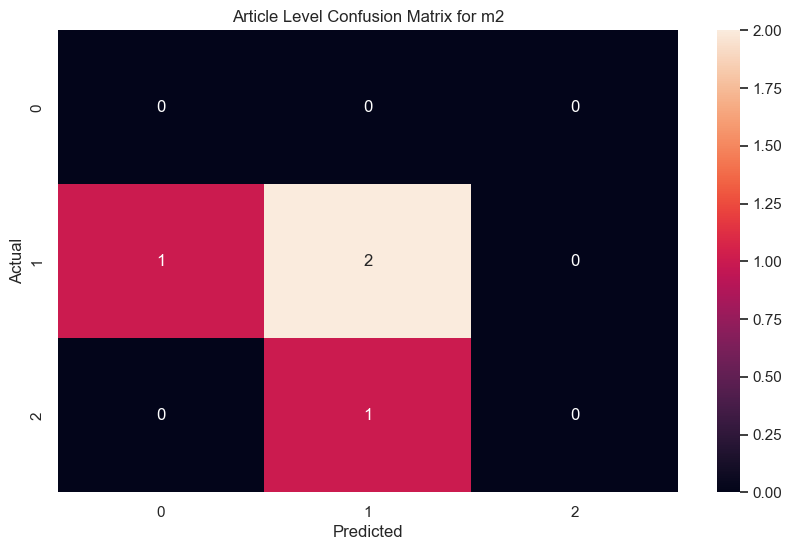

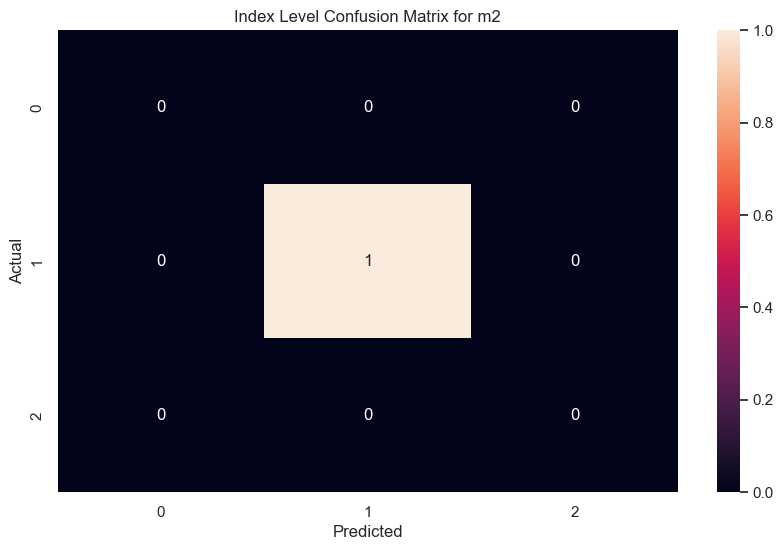

Article Level Results


,m1,m2
accuracy,0.500,0.500
precision,0.222,0.222
recall,0.222,0.222
f1,0.222,0.222


Index Level Results


,m1,m2
accuracy,1.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1,1.0,1.0


In [182]:
train_df_m2, test_df_m2 = prepare_setfit_datasets_m2(
    df_labelled,
    [
        "text",
        "mean_monthly_visits",
        "mean_monthly_unique_visitors",
        # "hours_since_published",
        # "day_of_week_published",
        # "hour_of_day_published",
        # "text_non_stop_word_count",
        # "text_subjectivity",
        # "text_sentiment",
        "article_index",
        "label",
    ],
    "m2",
)

train_evaluate_setfit_model(train_df_m2, test_df_m2, 'm2')


#### Model 2b:  SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors as bins)

In [183]:
def prepare_setfit_datasets_m2b(df_labelled, columns, method_name):
    df = df_labelled.copy()
    df = df[columns]

    df = df.groupby("article_index").filter(lambda x: len(x) > 1)
    
    # Normalise mean_monthly_visits and mean_monthly_unique_visitors
    df['mean_monthly_visits'] = df['mean_monthly_visits'] / df['mean_monthly_visits'].max()
    df['mean_monthly_unique_visitors'] = df['mean_monthly_unique_visitors'] / df['mean_monthly_unique_visitors'].max()

    # converting mean_monthly_visits and mean_monthly_unique_visitors to bin
    df['mean_monthly_visits'] = df['mean_monthly_visits'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))
    df['mean_monthly_unique_visitors'] = df['mean_monthly_unique_visitors'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))

    # # converting hours_since_published to bin
    # df['hours_since_published'] = df['hours_since_published'].apply(lambda x: "lowest" if x < 1 else ("low" if x < 2 else ("moderate" if x < 3 else "high")))

    # # converting text_non_stop_word_count to bin
    # df['text_non_stop_word_count'] = df['text_non_stop_word_count'].apply(lambda x: "lowest" if x < 5 else ("low" if x < 10 else ("moderate" if x < 15 else "high")))

    # # converting text_subjectivity to bin
    # df['text_subjectivity'] = df['text_subjectivity'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))

    # # converting text_sentiment to bin
    # df['text_sentiment'] = df['text_sentiment'].apply(lambda x: "lowest" if x < -0.25 else ("low" if x < 0 else ("moderate" if x < 0.25 else "high")))

    # # convert day_of_week_published to day
    # df['day_of_week_published'] = df['day_of_week_published'].apply(lambda x: "Monday" if x == 0 else ("Tuesday" if x == 1 else ("Wednesday" if x == 2 else ("Thursday" if x == 3 else ("Friday" if x == 4 else ("Saturday" if x == 5 else "Sunday"))))))

    df["text"] = (
        df["text"]
        + " There are "
        + df["mean_monthly_visits"].astype(str)
        + " mean monthly visitors to the website and "
        + df["mean_monthly_unique_visitors"].astype(str)
        + " mean monthly unique visitors to the website."

        # + " The article was published "
        # + df["hours_since_published"].astype(str)
        # + " hours after the last article of the same theme was published."
        # + " The article was published on the "
        # + df["day_of_week_published"].astype(str)
        # + " day of the week."
        # + " The article was published at the "
        # + df["hour_of_day_published"].astype(str)
        # + " hour of the day."
        # + " The headline has "
        # + df["text_non_stop_word_count"].astype(str)
        # + " non-stop words."
        # + " The text has a subjectivity score of "
        # + df["text_subjectivity"].astype(str)
        # + " and a sentiment score of "
        # + df["text_sentiment"].astype(str)
        # + "."
    )

    # split into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    train_df.to_parquet(f'data/train_df_{method_name}.parquet')
    test_df.to_parquet(f'data/test_df_{method_name}.parquet')

    dataset = load_dataset("parquet", data_files={'train': f"data/train_df_{method_name}.parquet", 'test': f"data/test_df_{method_name}.parquet"})
    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    return train_dataset, test_dataset



Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1960.87it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-9c51e36c0e2d792b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 997.46it/s]
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 2639.59it/s]
***** Running training *****
  Num examples = 600
  Num epochs = 1
  Total optimization steps = 38
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [00:32<00:00, 32.21s/it]
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefin

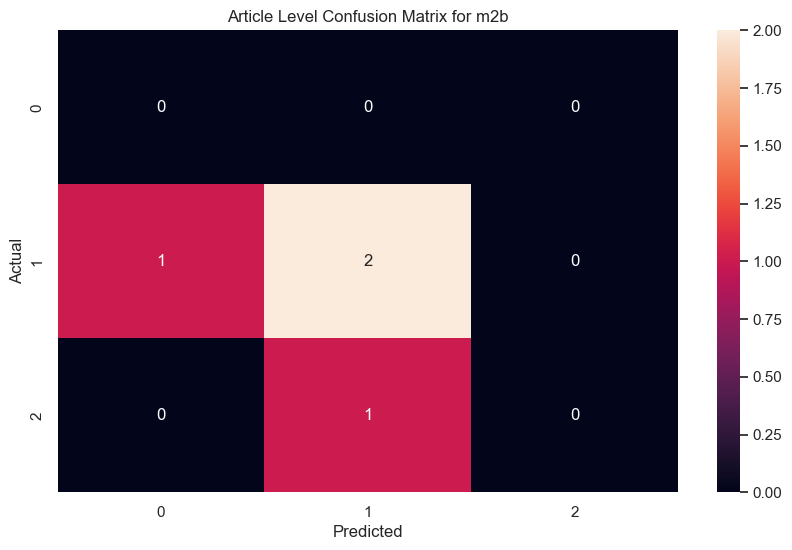

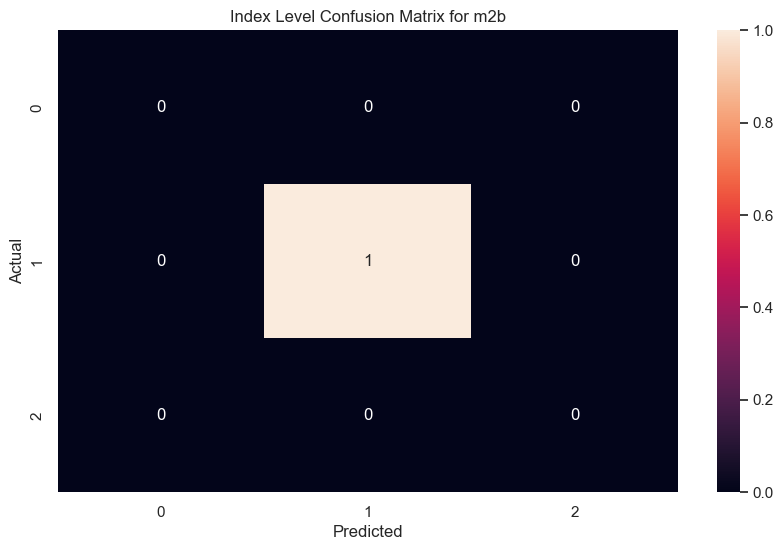

Article Level Results


,m1,m2,m2b
accuracy,0.500,0.500,0.500
precision,0.222,0.222,0.222
recall,0.222,0.222,0.222
f1,0.222,0.222,0.222


Index Level Results


,m1,m2,m2b
accuracy,1.0,1.0,1.0
precision,1.0,1.0,1.0
recall,1.0,1.0,1.0
f1,1.0,1.0,1.0


In [184]:
train_df_m2b, test_df_m2b = prepare_setfit_datasets_m2(
    df_labelled,
    [
        "text",
        "mean_monthly_visits",
        "mean_monthly_unique_visitors",
        # "hours_since_published",
        # "day_of_week_published",
        # "hour_of_day_published",
        # "text_non_stop_word_count",
        # "text_subjectivity",
        # "text_sentiment",
        "article_index",
        "label",
    ],
    "m2b",
)

train_evaluate_setfit_model(train_df_m2b, test_df_m2b, 'm2b')


#### Model 3: Combined models - Concat text embeddings with numerical features

In [185]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim import Adam

In [186]:
# Define the numeric model
class NumericModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NumericModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the final model
class FinalModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FinalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, numeric_cols):
        self.dataframe = dataframe
        self.numeric_cols = numeric_cols

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']  
        numeric = torch.tensor(row[self.numeric_cols].apply(pd.to_numeric).values, dtype=torch.float)  
        label = torch.tensor(row['label'], dtype=torch.long) 
        return text, numeric, label


# Function for training
def train(dataloader, sentence_model, numeric_model, final_model, criterion, optimizer):
    final_model.train()
    numeric_model.train()
    sentence_model.train()

    total_loss = 0

    for batch in dataloader:
        # Separate the text, numeric, and label data
        text_data, numeric_data, labels = batch

        # Convert text to embeddings
        text_embeddings = sentence_model.encode(text_data)

        # Pass numeric data through our numeric model
        numeric_embeddings = numeric_model(numeric_data)

        # Concatenate text and numeric embeddings
        combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

        # Pass through the final model
        predictions = final_model(combined_embeddings)

        # Reshape predictions
        predictions = predictions.squeeze()

        # Compute loss
        loss = criterion(predictions, labels.long())
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Function for evaluation
def evaluate(dataloader, sentence_model, numeric_model, final_model, criterion):
    final_model.eval()
    numeric_model.eval()
    sentence_model.eval()
    
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Separate the text, numeric, and label data
            text_data, numeric_data, labels = batch

            # Convert text to embeddings
            text_embeddings = sentence_model.encode(text_data)

            # Pass numeric data through our numeric model
            numeric_embeddings = numeric_model(numeric_data)

            # Concatenate text and numeric embeddings
            combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

            # Pass through the final model
            predictions = final_model(combined_embeddings)

            # Reshape predictions
            predictions = predictions.squeeze()

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

    return total_loss / len(dataloader)



In [187]:
def prepare_concat_datasets_m3(df_labelled, columns):
    df = df_labelled.copy()
    df = df[columns]
    df = df.groupby("article_index").filter(lambda x: len(x) > 1)

    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])
    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['article_index'])

    scaler_mean_monthly_visit = MinMaxScaler()
    train_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.fit_transform(train_df[['mean_monthly_visits']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df
    val_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(val_df[['mean_monthly_visits']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df
    test_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(test_df[['mean_monthly_visits']])

    scaler_mean_monthly_unique = MinMaxScaler()
    train_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.fit_transform(train_df[['mean_monthly_unique_visitors']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df
    val_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(val_df[['mean_monthly_unique_visitors']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df
    test_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(test_df[['mean_monthly_unique_visitors']])

    # # normalising hours_since_published on train_df
    # scaler_hours = MinMaxScaler()
    # train_df[['hours_since_published']] = scaler_hours.fit_transform(train_df[['hours_since_published']])

    # # normalising hours_since_published on val_df
    # val_df[['hours_since_published']] = scaler_hours.transform(val_df[['hours_since_published']])

    # # normalising hours_since_published on test_df
    # test_df[['hours_since_published']] = scaler_hours.transform(test_df[['hours_since_published']])

    # # normalising text_non_stop_word_count on train_df
    # scaler_text = MinMaxScaler()
    # train_df[['text_non_stop_word_count']] = scaler_text.fit_transform(train_df[['text_non_stop_word_count']])

    # # normalising text_non_stop_word_count on val_df
    # val_df[['text_non_stop_word_count']] = scaler_text.transform(val_df[['text_non_stop_word_count']])

    # # normalising text_non_stop_word_count on test_df
    # test_df[['text_non_stop_word_count']] = scaler_text.transform(test_df[['text_non_stop_word_count']])

    return train_df, val_df, test_df

def prepare_dataloaders(train_df, val_df, test_df, numeric_columns, batch_size=32):
    # Create Datasets
    train_dataset = CustomDataset(train_df, numeric_columns)
    val_dataset = CustomDataset(val_df, numeric_columns)
    test_dataset = CustomDataset(test_df, numeric_columns)

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def train_model(train_dataloader, val_dataloader, numeric_columns):
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Instantiate NumericModel
    numeric_model = NumericModel(len(numeric_columns), 64, 512)  

    # Instantiate FinalModel
    final_model = FinalModel(896, 64, 3)

    # Define the criterion and the optimizer
    criterion = nn.NLLLoss()
    # criterion = nn.CrossEntropyLoss()
    optimizer = Adam(list(numeric_model.parameters()) + list(final_model.parameters()) + list(sentence_model.parameters()), lr=0.0001)

    N_EPOCHS = 100

    # Save train and validation losses

    train_losses = []
    val_losses = []

    # Train and evaluate the model
    for epoch in range(N_EPOCHS):  
        train_loss = train(train_dataloader, sentence_model, numeric_model, final_model, criterion, optimizer)
        valid_loss = evaluate(val_dataloader, sentence_model, numeric_model, final_model, criterion)
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        print(f'Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {valid_loss}')

        # early stopping
        if epoch > 30 and val_losses[epoch-1] < val_losses[epoch] and val_losses[epoch-2] < val_losses[epoch-1]:
            break

    plot_loss_curves(train_losses, val_losses)

    return final_model, sentence_model, numeric_model

def predict_model(final_model, sentence_model, numeric_model, test_dataloader):
    final_model.eval()  # Set the model to evaluation mode
    sentence_model.eval()
    numeric_model.eval()

    pred_y = []  # Initialize an empty list to store predictions

    with torch.no_grad():  # No need to calculate gradients for evaluation
        for texts, numerics, _ in test_dataloader:  # We don't care about labels here
            texts = [sentence_model.encode(text) for text in texts]
            texts = torch.tensor(texts, dtype=torch.float)
            numerics = numeric_model(numerics)
            inputs = torch.cat((texts, numerics), dim=1)
            log_outputs = final_model(inputs)
            outputs = torch.exp(log_outputs)  # Convert to probabilities
            _, predicted = torch.max(outputs.data, 1)  # Choose the class with the highest score
            pred_y.extend(predicted.tolist())  # Convert tensor to list and append to predictions

    pred_y = np.array(pred_y)

    return pred_y

def evaluate_model(test_df, pred_y, method_name):
    test_y = test_df['label'].values
    article_level_result = evaluate_predictions(test_y, pred_y).rename(columns={'macro': method_name})
    test_y_agg, pred_y_agg = get_predictions_agg(test_df, pred_y)
    index_level_result = evaluate_predictions(test_y_agg, pred_y_agg).rename(columns={'macro': method_name})

    if method_name not in RESULTS_STORE:
        RESULTS_STORE[method_name] = {'article_level': [], 'index_level': []}
    RESULTS_STORE[method_name]['article_level'] = article_level_result.to_dict()[method_name]
    RESULTS_STORE[method_name]['index_level'] = index_level_result.to_dict()[method_name]

    plot_confusion_matrix(test_y, pred_y, 'Article Level Confusion Matrix for ' + method_name)
    plot_confusion_matrix(test_y_agg, pred_y_agg, 'Index Level Confusion Matrix for ' + method_name)

    print('Article Level Results')
    display(display_results_store_article())
    print('Index Level Results')
    display(display_results_store_index())



Epoch 0: Train Loss: 1.0983482599258423, Validation Loss: 1.096933364868164
Epoch 1: Train Loss: 1.0885707139968872, Validation Loss: 1.107240080833435
Epoch 2: Train Loss: 1.0792218446731567, Validation Loss: 1.1179877519607544
Epoch 3: Train Loss: 1.0702553987503052, Validation Loss: 1.1295181512832642
Epoch 4: Train Loss: 1.0617526769638062, Validation Loss: 1.1414546966552734
Epoch 5: Train Loss: 1.0535917282104492, Validation Loss: 1.1536575555801392
Epoch 6: Train Loss: 1.0458184480667114, Validation Loss: 1.1661349534988403
Epoch 7: Train Loss: 1.0386279821395874, Validation Loss: 1.1785143613815308
Epoch 8: Train Loss: 1.0318039655685425, Validation Loss: 1.1909700632095337
Epoch 9: Train Loss: 1.0254411697387695, Validation Loss: 1.2031806707382202
Epoch 10: Train Loss: 1.0191885232925415, Validation Loss: 1.2153080701828003
Epoch 11: Train Loss: 1.013229489326477, Validation Loss: 1.227117896080017
Epoch 12: Train Loss: 1.007709264755249, Validation Loss: 1.2382019758224487
E

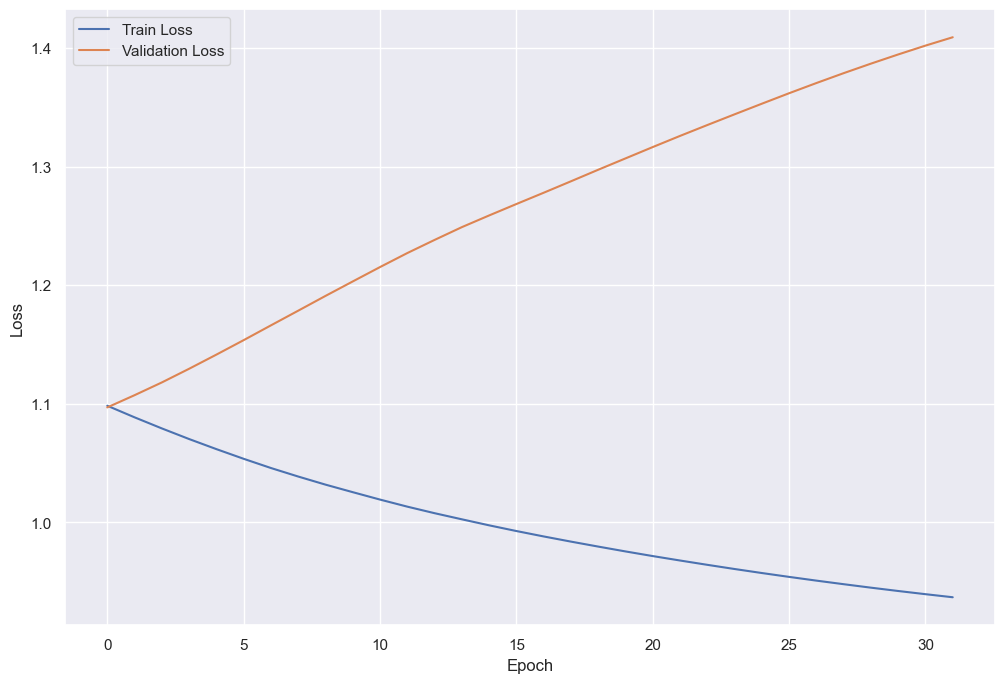

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


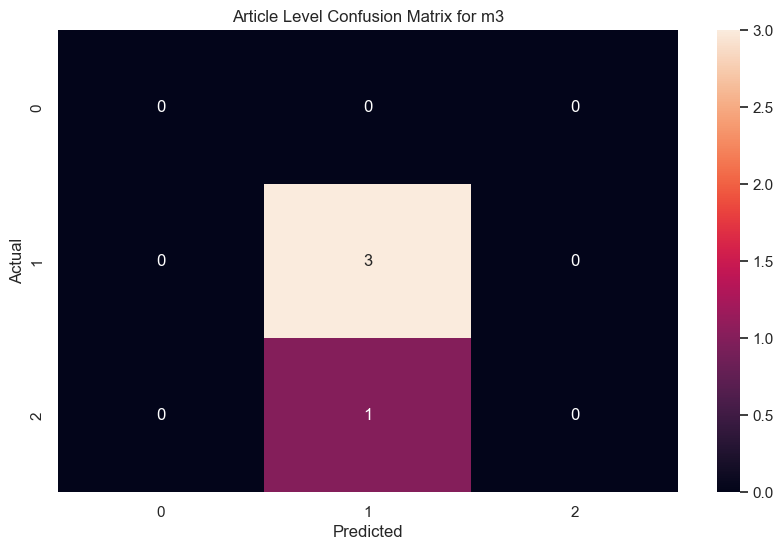

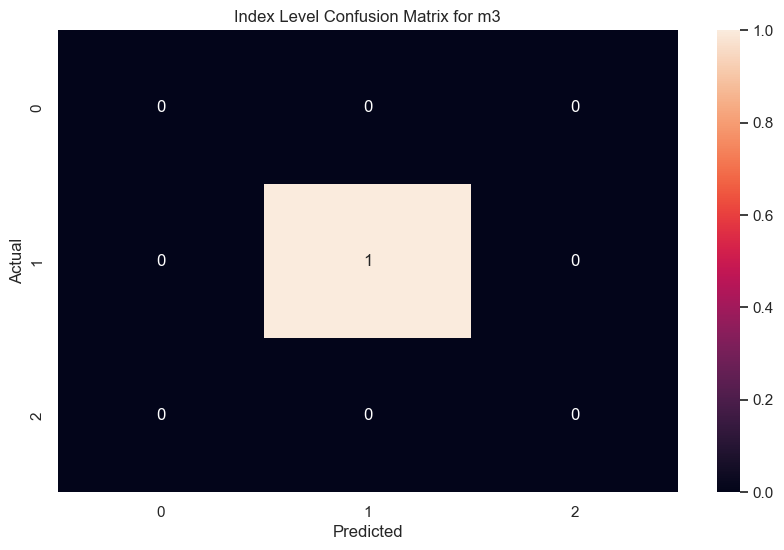

Article Level Results


,m1,m2,m2b,m3
accuracy,0.500,0.500,0.500,0.750
precision,0.222,0.222,0.222,0.375
recall,0.222,0.222,0.222,0.500
f1,0.222,0.222,0.222,0.429


Index Level Results


,m1,m2,m2b,m3
accuracy,1.0,1.0,1.0,1.0
precision,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0
f1,1.0,1.0,1.0,1.0


In [188]:
all_columns = [
    "text",
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
    "article_index",
    "label",
]

numeric_columns = [
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
]


train_df_m3, val_df_m3, test_df_m3 = prepare_concat_datasets_m3(
    df_labelled, all_columns
)

train_dataloader_m3, val_dataloader_m3, test_dataloader_m3 = prepare_dataloaders(
    train_df_m3, val_df_m3, test_df_m3, numeric_columns
)
final_model_m3, sentence_model_m3, numeric_model_m3 = train_model(
    train_dataloader_m3, val_dataloader_m3, numeric_columns
)
pred_y_m3 = predict_model(
    final_model_m3, sentence_model_m3, numeric_model_m3, test_dataloader_m3
)
evaluate_model(test_df_m3, pred_y_m3, "m3")

#### Model 3b:  Combined models - Concat text embeddings with numerical features (one hot encoding of domains only)

In [189]:
def prepare_concat_datasets_m3b(df_labelled, columns):
    df = df_labelled.copy()
    df = df[columns]
    df = df.groupby("article_index").filter(lambda x: len(x) > 1)

    df = pd.get_dummies(df, columns=['domain_group'])

    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])
    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['article_index'])

    scaler_mean_monthly_visit = MinMaxScaler()
    train_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.fit_transform(train_df[['mean_monthly_visits']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df
    val_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(val_df[['mean_monthly_visits']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df
    test_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(test_df[['mean_monthly_visits']])

    scaler_mean_monthly_unique = MinMaxScaler()
    train_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.fit_transform(train_df[['mean_monthly_unique_visitors']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df
    val_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(val_df[['mean_monthly_unique_visitors']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df
    test_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(test_df[['mean_monthly_unique_visitors']])

    # # normalising hours_since_published on train_df
    # scaler_hours = MinMaxScaler()
    # train_df[['hours_since_published']] = scaler_hours.fit_transform(train_df[['hours_since_published']])

    # # normalising hours_since_published on val_df
    # val_df[['hours_since_published']] = scaler_hours.transform(val_df[['hours_since_published']])

    # # normalising hours_since_published on test_df
    # test_df[['hours_since_published']] = scaler_hours.transform(test_df[['hours_since_published']])

    # # normalising text_non_stop_word_count on train_df
    # scaler_text = MinMaxScaler()
    # train_df[['text_non_stop_word_count']] = scaler_text.fit_transform(train_df[['text_non_stop_word_count']])

    # # normalising text_non_stop_word_count on val_df
    # val_df[['text_non_stop_word_count']] = scaler_text.transform(val_df[['text_non_stop_word_count']])

    # # normalising text_non_stop_word_count on test_df
    # test_df[['text_non_stop_word_count']] = scaler_text.transform(test_df[['text_non_stop_word_count']])

    return train_df, val_df, test_df

Epoch 0: Train Loss: 1.0951664447784424, Validation Loss: 1.1340147256851196
Epoch 1: Train Loss: 1.0878010988235474, Validation Loss: 1.138686180114746
Epoch 2: Train Loss: 1.0808624029159546, Validation Loss: 1.143120288848877
Epoch 3: Train Loss: 1.0743252038955688, Validation Loss: 1.1473628282546997
Epoch 4: Train Loss: 1.0681840181350708, Validation Loss: 1.1519380807876587
Epoch 5: Train Loss: 1.0623358488082886, Validation Loss: 1.1570014953613281
Epoch 6: Train Loss: 1.0566147565841675, Validation Loss: 1.1619744300842285
Epoch 7: Train Loss: 1.0510647296905518, Validation Loss: 1.1667269468307495
Epoch 8: Train Loss: 1.0456289052963257, Validation Loss: 1.171392560005188
Epoch 9: Train Loss: 1.040239691734314, Validation Loss: 1.1760741472244263
Epoch 10: Train Loss: 1.0349620580673218, Validation Loss: 1.1809622049331665
Epoch 11: Train Loss: 1.0298057794570923, Validation Loss: 1.1858989000320435
Epoch 12: Train Loss: 1.0248479843139648, Validation Loss: 1.1905533075332642


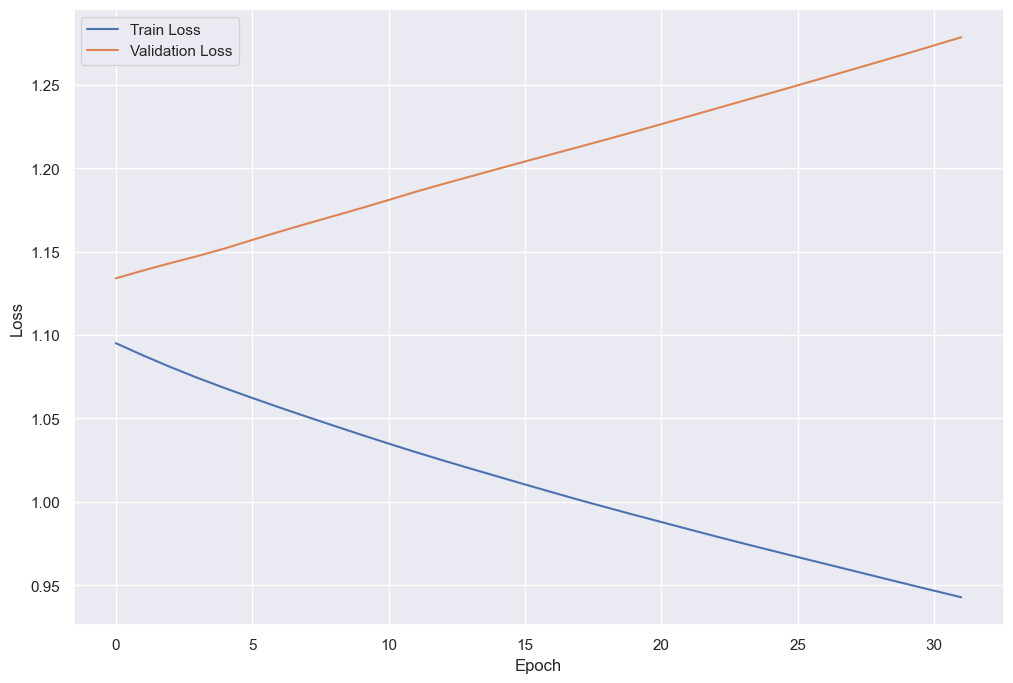

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


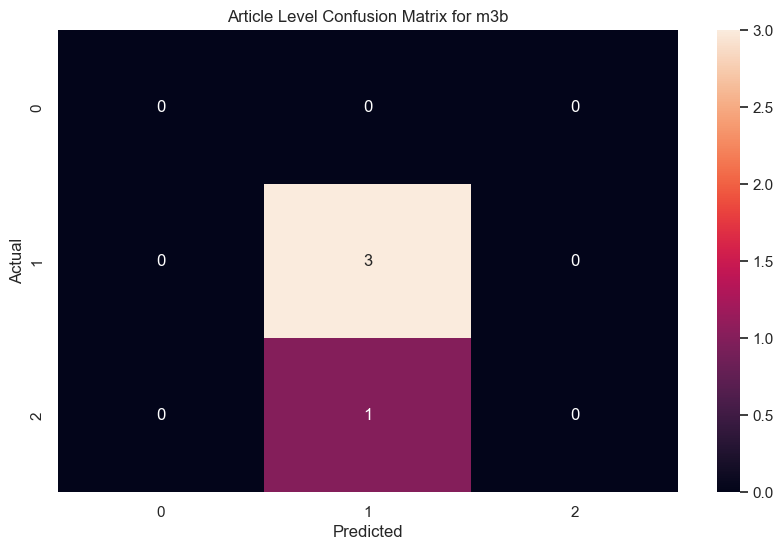

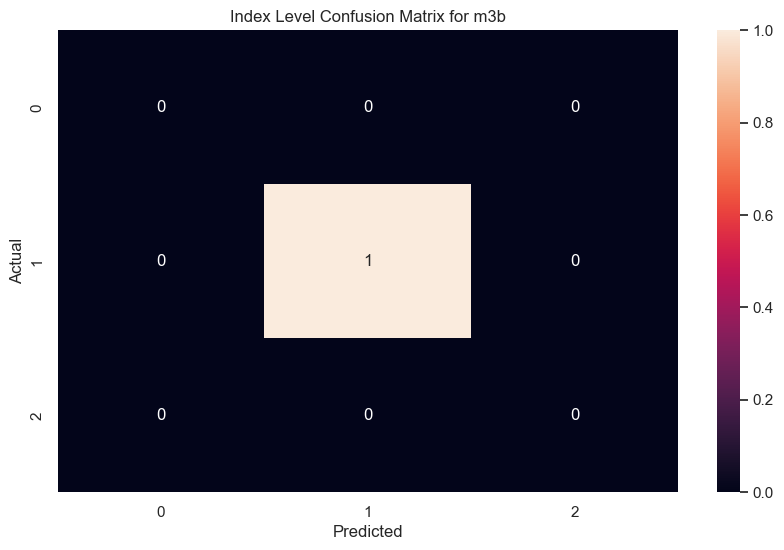

Article Level Results


,m1,m2,m2b,m3,m3b
accuracy,0.500,0.500,0.500,0.750,0.750
precision,0.222,0.222,0.222,0.375,0.375
recall,0.222,0.222,0.222,0.500,0.500
f1,0.222,0.222,0.222,0.429,0.429


Index Level Results


,m1,m2,m2b,m3,m3b
accuracy,1.0,1.0,1.0,1.0,1.0
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1,1.0,1.0,1.0,1.0,1.0


In [190]:
all_columns = [
    "text",
    'domain_group',
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
    "article_index",
    "label",
]

numeric_columns = [
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
]

train_df_m3b, val_df_m3b, test_df_m3b = prepare_concat_datasets_m3b(
    df_labelled, all_columns
)

domain_group_cols = [i for i in train_df_m3b.columns if "domain_group" in i]
numeric_columns = numeric_columns + domain_group_cols

train_dataloader_m3b, val_dataloader_m3b, test_dataloader_m3b = prepare_dataloaders(
    train_df_m3b, val_df_m3b, test_df_m3b, numeric_columns
)
final_model_m3b, sentence_model_m3b, numeric_model_m3b = train_model(
    train_dataloader_m3b, val_dataloader_m3b, numeric_columns
)
pred_y_m3b = predict_model(
    final_model_m3b, sentence_model_m3b, numeric_model_m3b, test_dataloader_m3b
)
evaluate_model(test_df_m3b, pred_y_m3b, "m3b")

#### Model 4: Multimodal Transformers

In [191]:
import pandas as pd
from multimodal_transformers.data import load_data
from transformers import AutoTokenizer
from multimodal_transformers.model import AutoModelWithTabular, TabularConfig
from transformers import AutoConfig
from transformers import Trainer, TrainingArguments


In [192]:
def prepare_multimodal_datasets_m4(df_labelled, all_columns, numerical_cols, method_name):
    df = df_labelled.copy()
    df = df[all_columns]
    df = df.groupby("article_index").filter(lambda x: len(x) > 1)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    scaler_mean_monthly_visit = MinMaxScaler()
    train_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.fit_transform(train_df[['mean_monthly_visits']])
    test_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(test_df[['mean_monthly_visits']])

    scaler_mean_monthly_unique = MinMaxScaler()
    train_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.fit_transform(train_df[['mean_monthly_unique_visitors']])
    test_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(test_df[['mean_monthly_unique_visitors']])

    # scaler_hours = MinMaxScaler()
    # train_df[['hours_since_published']] = scaler_hours.fit_transform(train_df[['hours_since_published']])
    # test_df[['hours_since_published']] = scaler_hours.transform(test_df[['hours_since_published']])

    # scaler_text = MinMaxScaler()
    # train_df[['text_non_stop_word_count']] = scaler_text.fit_transform(train_df[['text_non_stop_word_count']])
    # test_df[['text_non_stop_word_count']] = scaler_text.transform(test_df[['text_non_stop_word_count']])

    text_cols = ['text']
    label_col = 'label' 
    label_list = ['diminishing', 'neutral', 'trending']

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    train_dataset = load_data(
        df,
        text_cols,
        tokenizer,
        numerical_cols=numerical_cols,
        label_col=label_col,
        sep_text_token_str=tokenizer.sep_token
    )

    test_dataset = load_data(
        test_df,
        text_cols,
        tokenizer,
        numerical_cols=numerical_cols,
        label_col=label_col,
        sep_text_token_str=tokenizer.sep_token
    )

    return train_dataset, test_dataset

def train_model(train_dataset, test_dataset):
    num_labels = 3
    config = AutoConfig.from_pretrained('bert-base-uncased')
    tabular_config = TabularConfig(
        num_labels=num_labels,
        numerical_feat_dim=train_dataset.numerical_feats.shape[1],
        combine_feat_method='weighted_feature_sum_on_transformer_cat_and_numerical_feats',
    )
    config.tabular_config = tabular_config

    model = AutoModelWithTabular.from_pretrained('bert-base-uncased', config=config)

    training_args = TrainingArguments(
        output_dir="./logs/model_name",
        logging_dir="./logs/runs",
        overwrite_output_dir=True,
        do_train=True,
        per_device_train_batch_size=32,
        num_train_epochs=5,
        # evaluate_during_training=True,
        logging_steps=25,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    trainer.train()

    return trainer


def evaluate_model(test_dataset, trainer, method_name):
    pred_y = trainer.predict(test_dataset)
    pred_y = pred_y.predictions[0].argmax(axis=1)
    test_y = test_dataset.df['label'].values
    
    article_level_result = evaluate_predictions(test_y, pred_y).rename(columns={'macro': method_name})
    test_y_agg, pred_y_agg = get_predictions_agg(test_dataset.df, pred_y)
    index_level_result = evaluate_predictions(test_y_agg, pred_y_agg).rename(columns={'macro': method_name})

    if method_name not in RESULTS_STORE:
        RESULTS_STORE[method_name] = {'article_level': [], 'index_level': []}
    RESULTS_STORE[method_name]['article_level'] = article_level_result.to_dict()[method_name]
    RESULTS_STORE[method_name]['index_level'] = index_level_result.to_dict()[method_name]

    plot_confusion_matrix(test_y, pred_y, 'Article Level Confusion Matrix for ' + method_name)
    plot_confusion_matrix(test_y_agg, pred_y_agg, 'Index Level Confusion Matrix for ' + method_name)

    print('Article Level Results')
    display(display_results_store_article())
    print('Index Level Results')
    display(display_results_store_index())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['tabular_combiner.num_layer.weight', 'tabul

{'train_runtime': 3.2203, 'train_samples_per_second': 5.9, 'train_steps_per_second': 0.311, 'train_loss': 1.0361194610595703, 'epoch': 1.0}


100%|██████████| 1/1 [00:00<?, ?it/s]
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


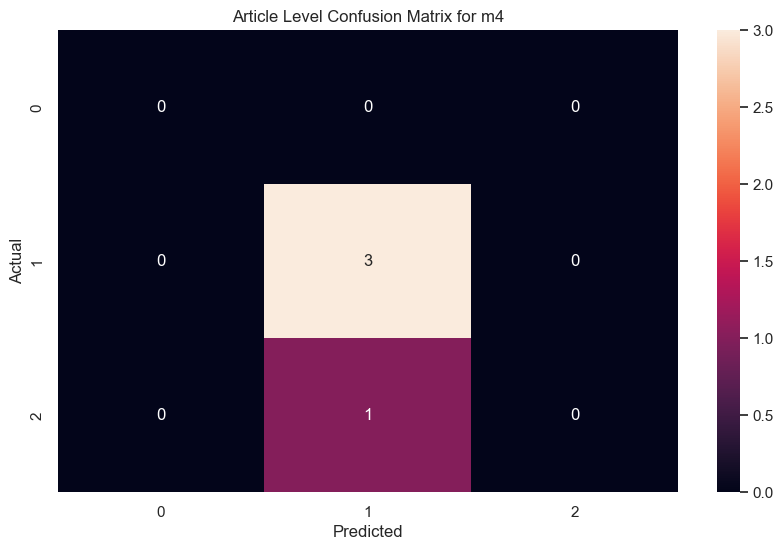

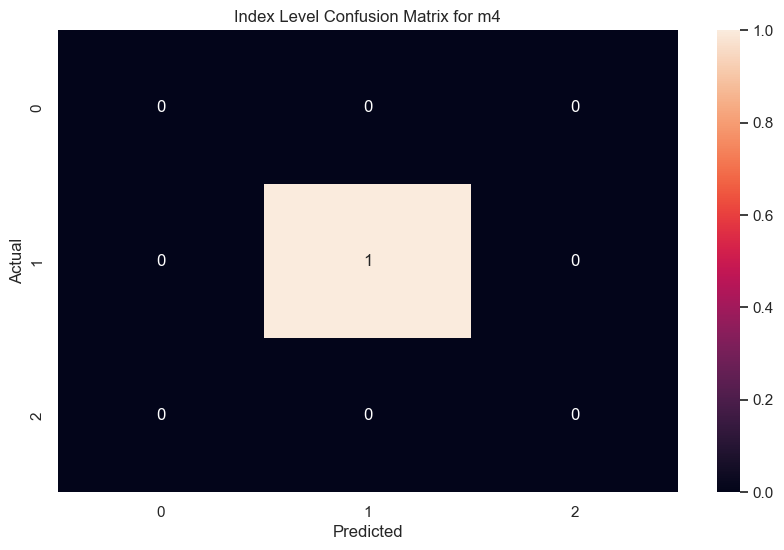

Article Level Results


,m1,m2,m2b,m3,m3b,m4
accuracy,0.500,0.500,0.500,0.750,0.750,0.750
precision,0.222,0.222,0.222,0.375,0.375,0.375
recall,0.222,0.222,0.222,0.500,0.500,0.500
f1,0.222,0.222,0.222,0.429,0.429,0.429


Index Level Results


,m1,m2,m2b,m3,m3b,m4
accuracy,1.0,1.0,1.0,1.0,1.0,1.0
precision,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0
f1,1.0,1.0,1.0,1.0,1.0,1.0


In [193]:
all_columns = [
    "text",
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
    "article_index",
    "label",
]

numerical_cols = [
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published"
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
]

train_dataset_m4, test_dataset_m4 = prepare_multimodal_datasets_m4(
    df_labelled, all_columns, numerical_cols, "m4"
)

trainer_m4 = train_model(train_dataset_m4, test_dataset_m4)

evaluate_model(test_dataset_m4, trainer_m4, 'm4')

#### Model 4b. Multimodel Transformers with categorical domain encoding

In [194]:
def prepare_multimodal_datasets_m4b(df_labelled, all_columns, numerical_cols, method_name):
    df = df_labelled.copy()
    df = df[all_columns]
    df = df.groupby("article_index").filter(lambda x: len(x) > 1)
    df = pd.get_dummies(df, columns=['domain_group'])

    domain_group_cols = [i for i in df.columns if "domain_group" in i]
    numerical_cols = numerical_cols + domain_group_cols

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    scaler_mean_monthly_visit = MinMaxScaler()
    train_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.fit_transform(train_df[['mean_monthly_visits']])
    test_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(test_df[['mean_monthly_visits']])

    scaler_mean_monthly_unique = MinMaxScaler()
    train_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.fit_transform(train_df[['mean_monthly_unique_visitors']])
    test_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(test_df[['mean_monthly_unique_visitors']])

    # scaler_hours = MinMaxScaler()
    # train_df[['hours_since_published']] = scaler_hours.fit_transform(train_df[['hours_since_published']])
    # test_df[['hours_since_published']] = scaler_hours.transform(test_df[['hours_since_published']])

    # scaler_text = MinMaxScaler()
    # train_df[['text_non_stop_word_count']] = scaler_text.fit_transform(train_df[['text_non_stop_word_count']])
    # test_df[['text_non_stop_word_count']] = scaler_text.transform(test_df[['text_non_stop_word_count']])

    text_cols = ['text']
    label_col = 'label' 
    label_list = ['diminishing', 'neutral', 'trending']

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    train_dataset = load_data(
        df,
        text_cols,
        tokenizer,
        numerical_cols=numerical_cols,
        label_col=label_col,
        sep_text_token_str=tokenizer.sep_token
    )

    test_dataset = load_data(
        test_df,
        text_cols,
        tokenizer,
        numerical_cols=numerical_cols,
        label_col=label_col,
        sep_text_token_str=tokenizer.sep_token
    )

    return train_dataset, test_dataset

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['tabular_combiner.num_layer.weight', 'tabul

{'train_runtime': 5.758, 'train_samples_per_second': 3.3, 'train_steps_per_second': 0.174, 'train_loss': 1.0664114952087402, 'epoch': 1.0}


100%|██████████| 1/1 [00:00<00:00, 1001.27it/s]
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


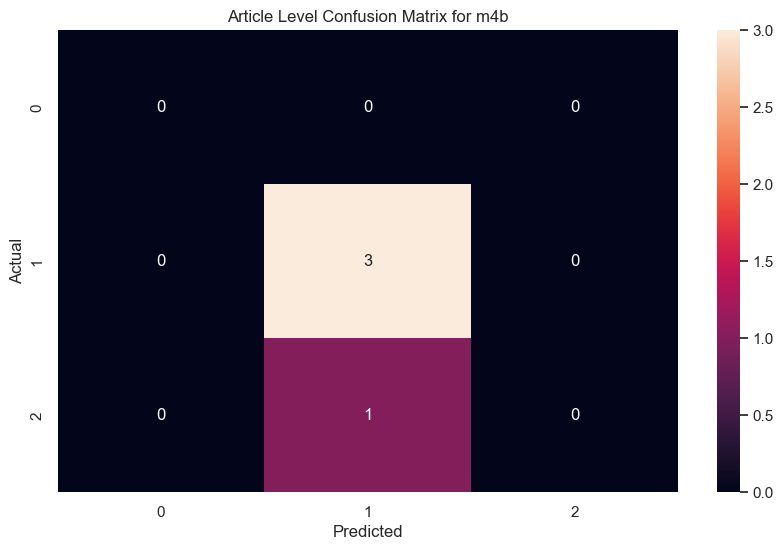

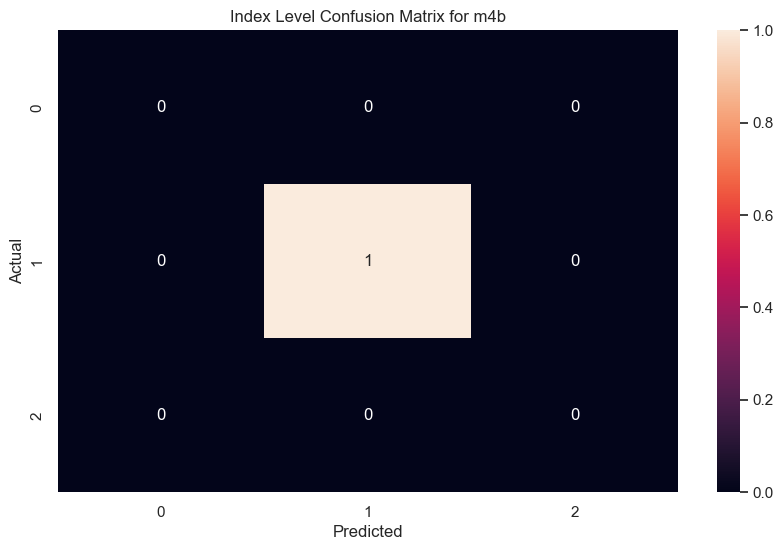

Article Level Results


,m1,m2,m2b,m3,m3b,m4,m4b
accuracy,0.500,0.500,0.500,0.750,0.750,0.750,0.750
precision,0.222,0.222,0.222,0.375,0.375,0.375,0.375
recall,0.222,0.222,0.222,0.500,0.500,0.500,0.500
f1,0.222,0.222,0.222,0.429,0.429,0.429,0.429


Index Level Results


,m1,m2,m2b,m3,m3b,m4,m4b
accuracy,1.0,1.0,1.0,1.0,1.0,1.0,1.0
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0
f1,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [195]:
all_columns = [
    "text",
    "domain_group",
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
    "article_index",
    "label",
]

numerical_cols = [
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published"
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
]

train_dataset_m4b, test_dataset_m4b = prepare_multimodal_datasets_m4b(
    df_labelled, all_columns, numerical_cols, "m4b"
)

trainer_m4b = train_model(train_dataset_m4b, test_dataset_m4b)

evaluate_model(test_dataset_m4b, trainer_m4b, 'm4b')


